In [6]:
#Scenario Building
#This program is used to build the scenarios for San Clemente Island
#It utizilises synthesized load data, and solar and wind supply curves from 
#renewable ninja and and power curves
#It enables the scaling and simulation of solar, wind, storage, nuclear, and diesel 

In [88]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import time
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.patches as mpatches

#make plot default more academic (bold axis, etc)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 12


In [8]:
#import the necessary data
# Load the simulated load data
sim_data = pd.read_csv('sim_data.csv')
# Load the solar and wind data
solar_data = pd.read_csv('solarfinalannum.csv')
wind_data = pd.read_csv('Windfinalannum.csv')
#make nuclear data with the same first column and a second column ('kWh') of matching length with repeated 2000s
nuclear_data = pd.DataFrame(sim_data['Date'])
nuclear_data['kWh'] = 2000.0 #set the eletrical capacity of the nuclear plant 

sim_data.set_index('Date', inplace=True)
solar_data.set_index('Date', inplace = True)
wind_data.set_index('Date', inplace = True)
nuclear_data.set_index('Date', inplace = True)
#convert all indices to datetime
sim_data.index = pd.to_datetime(sim_data.index)
solar_data.index = pd.to_datetime(solar_data.index)
wind_data.index = pd.to_datetime(wind_data.index)
nuclear_data.index = pd.to_datetime(nuclear_data.index)
#check tht the lengths are equal
#print(len(sim_data_inf))
#print(len(solar_data))
#print(len(wind_data))

In [9]:
#infrastructure counts for code
turbinenumber = 0.0
solarcount = 100000
nucleargens = 0.0
wind = turbinenumber*wind_data['kWh']
solar = solarcount*solar_data['kWh']
nuclear = nucleargens*nuclear_data['kWh']
demand = sim_data['smoothed']
supplyr = wind+solar+nuclear
print(supplyr)

Date
1999-01-01 00:30:00    0.0
1999-01-01 01:30:00    0.0
1999-01-01 02:30:00    0.0
1999-01-01 03:30:00    0.0
1999-01-01 04:30:00    0.0
                      ... 
1999-12-31 19:30:00    0.0
1999-12-31 20:30:00    0.0
1999-12-31 21:30:00    0.0
1999-12-31 22:30:00    0.0
1999-12-31 23:30:00    0.0
Name: kWh, Length: 8760, dtype: float64


In [10]:
#Diesel 
#Can operate at 500, 750, 1200 or 1700 kW
#take the demand and subtract the supply. The diesel will be making up the difference
# round the diesel to the nearest one of its operatable values 
# the four values are 500, 750, 1200, 1700
diesel = []
fuel = []



opcap = 500
coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve
def galcalc(opcap, op):
    outp = op/opcap*100
    eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
    kwh = op/eff
    gal = kwh/37.5
    return gal

p = np.poly1d(coeffs)
for i in supplyr-demand:
    if i > 0:
        diesel.append(0)
        fuel.append(0)
    else:
        if i > -500:
            diesel.append(-i)
            opcap = 500
            fuel.append(galcalc(opcap, -i))
            
        elif i > -750:
            opcap = 750
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        elif i > -1200:
            opcap = 1200
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        else:
            opcap = 1700
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
supplytotal = wind + solar + nuclear + diesel
diesel_data = pd.DataFrame(sim_data.index)
diesel_data['kWh'] = diesel
diesel_data.set_index('Date', inplace = True)

#repeat with fuel 
fuel_data = pd.DataFrame(sim_data.index)
fuel_data['gal'] = fuel
fuel_data.set_index('Date', inplace = True)

#make fuel data cumulative
fuel_data['cumulative'] = fuel_data['gal'].cumsum()


In [11]:
#Battery no Diesel 
 #Battery
battery = []
battpower = 5000
battcap = 10000
charge = battcap
discharge = []
curtailed = []
curtail = 0
for i in supplyr-demand:
    if i > 0:
        if i > battpower:
            charge = charge + battpower
            curtail = i-battpower
        else:
            charge = charge + i
            curtail = 0 
        if charge > battcap:
            curtail = curtail + charge - battcap
            charge = battcap
        battery.append(charge)
        discharge.append(0)
        curtailed.append(curtail)
    else:
        if i < -battpower:
            charge = charge - battpower
            if charge <= 0:
                discharge.append(charge + battpower)
                charge = 0
            else:
                discharge.append(battpower)
        else:
            charge = charge + i
            if charge <= 0:
                discharge.append(charge-i)
                charge = 0
            else:
                discharge.append(-i)
        battery.append(charge)
        curtailed.append(0)
    curtail = 0

battery = np.array(battery)
battery_data = pd.DataFrame(sim_data.index)
battery_data['kWh'] = battery
battery_data.set_index('Date', inplace = True)

discharge = np.array(discharge)
discharge_data = pd.DataFrame(sim_data.index)
discharge_data['kWh'] = discharge
discharge_data.set_index('Date', inplace = True)

Total Fuel Used: 611649.883912285


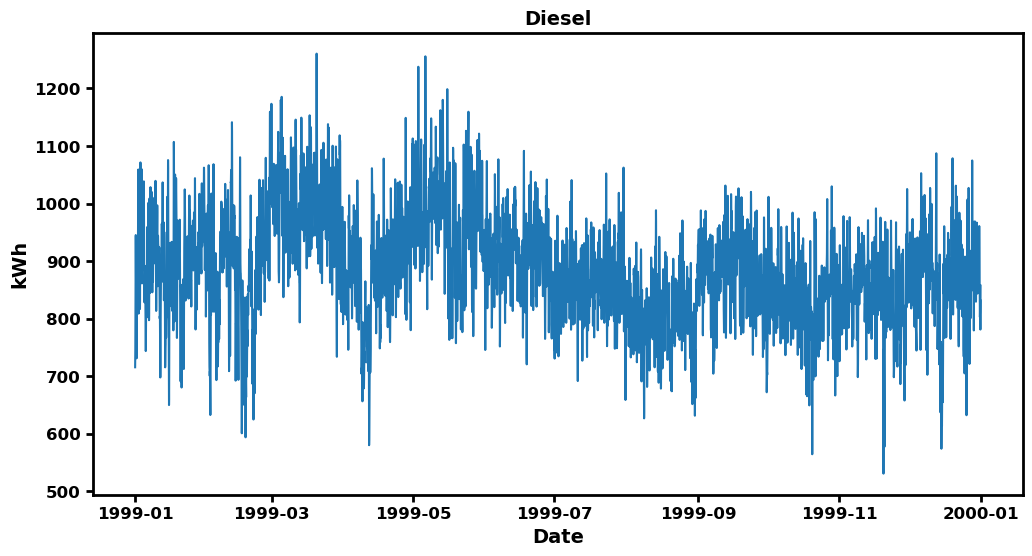

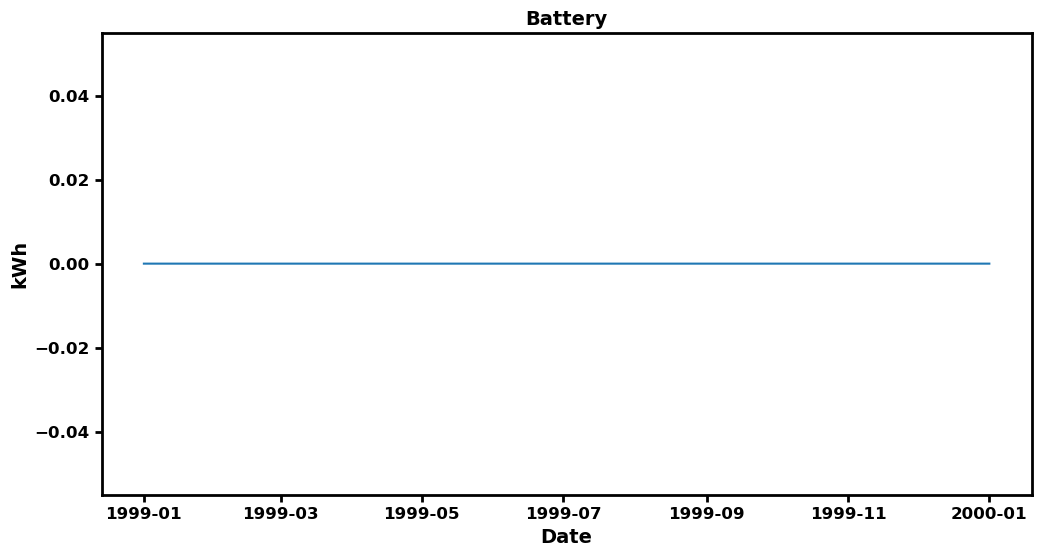

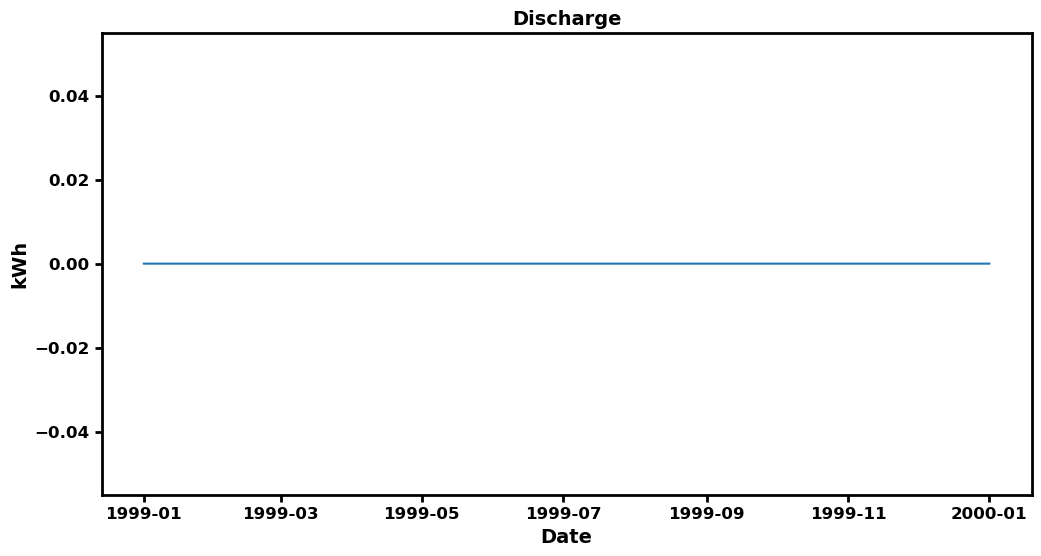

In [38]:
#Battery with Diesel tester
# Use the function arguments to calculate wind, solar, and nuclear
turbinenumber = 1 
solarcount = 0
nucleargens = 0.0
wind = turbinenumber*wind_data['kWh']
solar = solarcount*solar_data['kWh']
nuclear = nucleargens*nuclear_data['kWh']

# Calculate the supply
supplyr = wind+solar+nuclear

    #Battery
battery = []
battcap = 0
battpower = 0
charge = battcap
discharge = []
curtailed = []
curtail = 0
for i in supplyr-demand:
    if i > 0:
        if i > battpower:
            charge = charge + battpower
            curtail = i-battpower
        else:
            charge = charge + i
            curtail = 0 
        if charge > battcap:
            curtail = curtail + charge - battcap
            charge = battcap
        battery.append(charge)
        discharge.append(0)
        curtailed.append(curtail)
    else:
        if i < -battpower:
            charge = charge - battpower
            if charge <= 0:
                discharge.append(charge + battpower)
                charge = 0
            else:
                discharge.append(battpower)
        else:
            charge = charge + i
            if charge <= 0:
                discharge.append(charge-i)
                charge = 0
            else:
                discharge.append(-i)
        battery.append(charge)
        curtailed.append(0)
    curtail = 0

supplyrb = wind + solar + nuclear + discharge
    # Calculate the diesel needed
diesel = []
fuel = []



opcap = 500
coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve
def galcalc(opcap, op):
    outp = op/opcap*100
    eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
    kwh = op/eff
    gal = kwh/37.5
    return gal

p = np.poly1d(coeffs)
count = -1
for i in supplyrb-demand:
    count = count+1
    if i > 0:
        diesel.append(0)
        fuel.append(0)
    else:
        if i > -250:
            diesel.append(250)
            opcap = 500
            fuel.append(galcalc(opcap, 250))
        elif i > -500:
            diesel.append(-i)
            opcap = 500
            fuel.append(galcalc(opcap, -i))
            
        elif i > -750:
            opcap = 750
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        elif i > -1200:
            opcap = 1200
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        else:
            opcap = 1700
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
    if diesel[-1] + i > 0 and diesel[-1] != 0:
        curtailed[count] = diesel[-1] + i
        
supplytotal = wind + solar + nuclear + diesel + discharge
diesel_data = pd.DataFrame(sim_data.index)
diesel_data['kWh'] = diesel
diesel_data.set_index('Date', inplace = True)

#repeat with fuel 
fuel_data = pd.DataFrame(sim_data.index)
fuel_data['gal'] = fuel
fuel_data.set_index('Date', inplace = True)

#make fuel data cumulative
fuel_data['cumulative'] = fuel_data['gal'].cumsum()

    

# Create the diesel DataFrame
diesel_data = pd.DataFrame(sim_data.index)
diesel_data['kWh'] = diesel
diesel_data.set_index('Date', inplace = True)
supplytotal = wind+solar+nuclear+diesel
    # Calculate the total supply
supplytotal = wind + solar + nuclear + diesel +discharge
# Create the battery DataFrame
battery = np.array(battery)
battery_data = pd.DataFrame(sim_data.index)
battery_data['kWh'] = battery
battery_data.set_index('Date', inplace = True)

#create the discharge DataFrame
discharge = np.array(discharge)
discharge_data = pd.DataFrame(sim_data.index)
discharge_data['kWh'] = discharge
discharge_data.set_index('Date', inplace = True)


# Plot the diesel data
plt.figure(figsize=(12, 6))
plt.plot(diesel_data, label='Diesel')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Diesel')

# Plot the battery data
plt.figure(figsize=(12, 6))
plt.plot(battery_data, label='Battery')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Battery')

# Plot the discharge data
plt.figure(figsize=(12, 6))
plt.plot(discharge_data, label='Discharge')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Discharge')

#print total amount of fuel used
print('Total Fuel Used:', fuel_data['gal'].sum())

In [13]:
#Battery w/ Diesel 
battery = []
battcap = 5000 #kwH
battpower = 1000 #kW
charge = battcap
discharge = []
curtailed = []
for i in supplyr-demand:
    if i >= 0:
        if i > battpower:
            charge = charge + battpower
            curtailed.append(i-battpower)
        else:
            charge = charge + i
        if charge > battcap:
            charge = battcap
        battery.append(charge)
        discharge.append(0)
    else:
        if i < -battpower:
            charge = charge - battpower
            if charge <= 0:
                discharge.append(charge + battpower)
                charge = 0
            else:
                discharge.append(battpower)
        else:
            charge = charge + i
            if charge <= 0:
                discharge.append(charge-i)
                charge = 0
            else:
                discharge.append(-i)
        battery.append(charge)
supplyr = wind + solar + nuclear + discharge
diesel = []
fuel = []
for i in supplyr-demand:
    if i > 0:
        diesel.append(0)
        fuel.append(0)
    else:
        if i > -500:
            diesel.append(-i)
            opcap = 500
            fuel.append(galcalc(opcap, -i))
            
        elif i > -750:
            opcap = 750
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        elif i > -1200:
            opcap = 1200
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))
        else:
            opcap = 1700
            diesel.append(-i)
            fuel.append(galcalc(opcap, -i))

battery = np.array(battery)
battery_data = pd.DataFrame(sim_data.index)
battery_data['kWh'] = battery
battery_data.set_index('Date', inplace = True)

discharge = np.array(discharge)
discharge_data = pd.DataFrame(sim_data.index)
discharge_data['kWh'] = discharge
discharge_data.set_index('Date', inplace = True)

#repeat with fuel 
fuel_data = pd.DataFrame(sim_data.index)
fuel_data['gal'] = fuel
fuel_data.set_index('Date', inplace = True)

#make fuel data cumulative
fuel_data['cumulative'] = fuel_data['gal'].cumsum()

Date
1999-01-01 00:30:00      -0.000000
1999-01-01 01:30:00      -0.000000
1999-01-01 02:30:00      -0.000000
1999-01-01 03:30:00      -0.000000
1999-01-01 04:30:00      -0.000000
1999-01-01 05:30:00      -0.000000
1999-01-01 06:30:00      49.258444
1999-01-01 07:30:00     122.720155
1999-01-01 08:30:00     194.287404
1999-01-01 09:30:00     263.347054
1999-01-01 10:30:00     330.461045
1999-01-01 11:30:00     396.887907
1999-01-01 12:30:00     462.986579
1999-01-01 13:30:00     527.974911
1999-01-01 14:30:00     591.188358
1999-01-01 15:30:00     645.600944
1999-01-01 16:30:00     700.049879
1999-01-01 17:30:00     763.635564
1999-01-01 18:30:00     830.076691
1999-01-01 19:30:00     899.291576
1999-01-01 20:30:00     970.288935
1999-01-01 21:30:00    1042.048830
1999-01-01 22:30:00    1113.985708
1999-01-01 23:30:00    1185.777770
Name: cumulative, dtype: float64


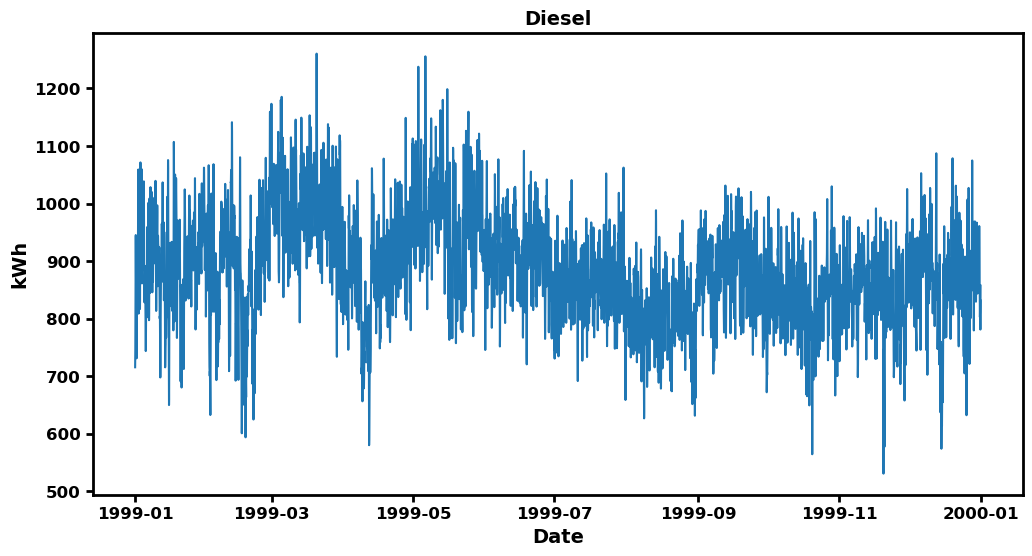

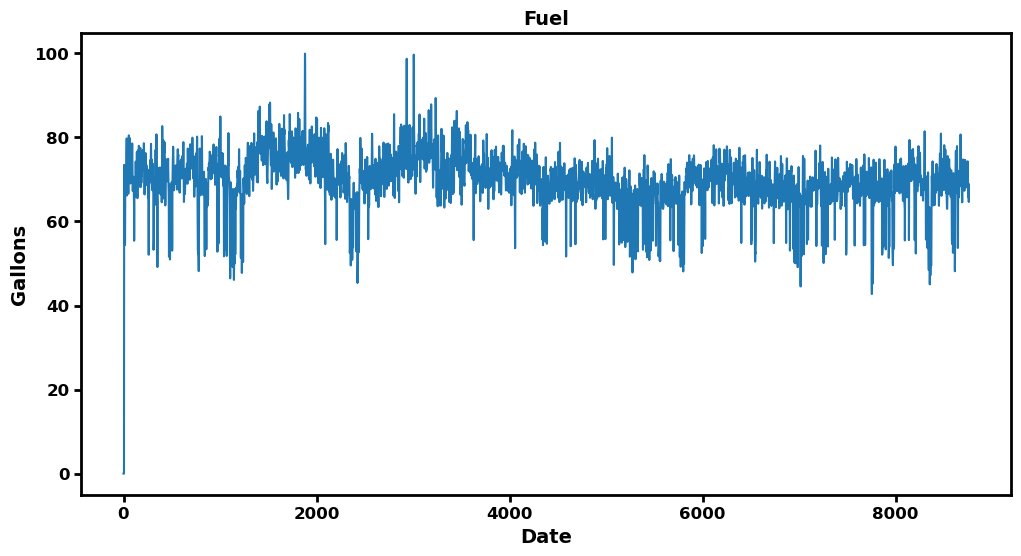

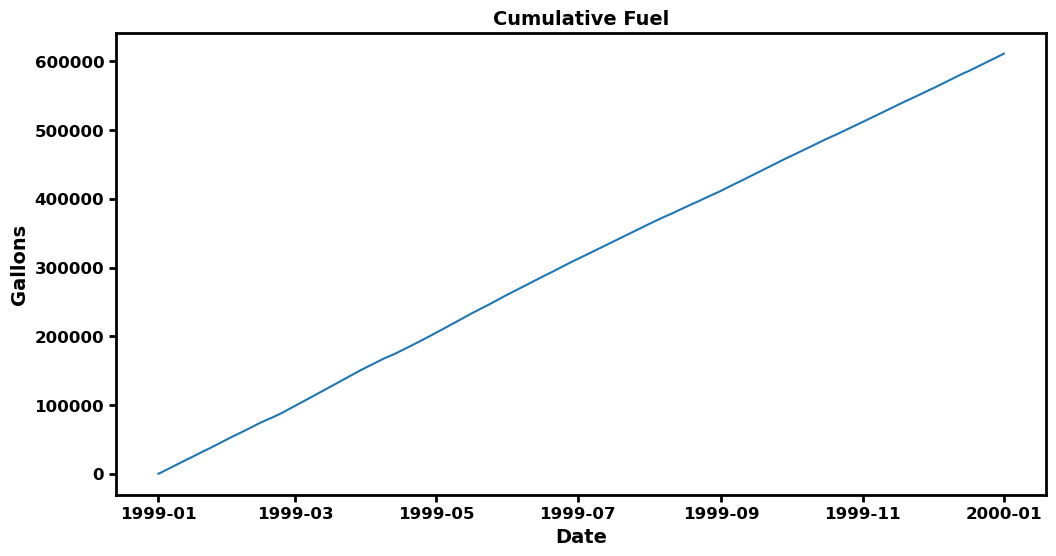

In [14]:
#Plot Diesel
plt.figure(figsize=(12, 6))
plt.plot(diesel_data, label='Diesel')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Diesel')

# plot fuel
plt.figure(figsize=(12, 6))
plt.plot(fuel, label='Fuel')
plt.xlabel('Date')
plt.ylabel('Gallons')
plt.title('Fuel')

#plot cumutlative fuel
plt.figure(figsize=(12, 6))
plt.plot(fuel_data['cumulative'], label='Cumulative Fuel')
plt.xlabel('Date')
plt.ylabel('Gallons')
plt.title('Cumulative Fuel')

#check fuel consumption on jan 1 1999 
print(fuel_data['cumulative'].loc['1999-01-01'])


Text(0.5, 1.0, 'Curtailed')

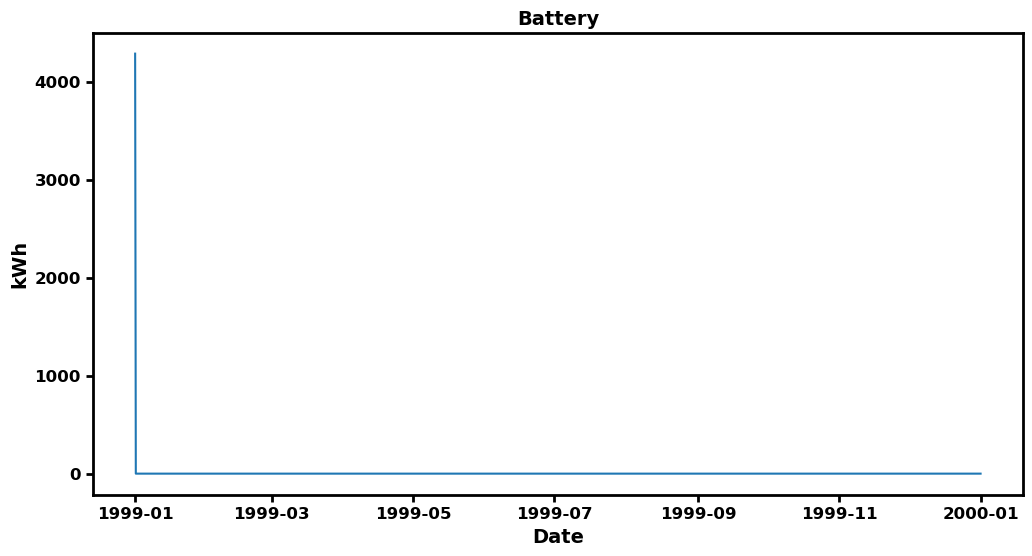

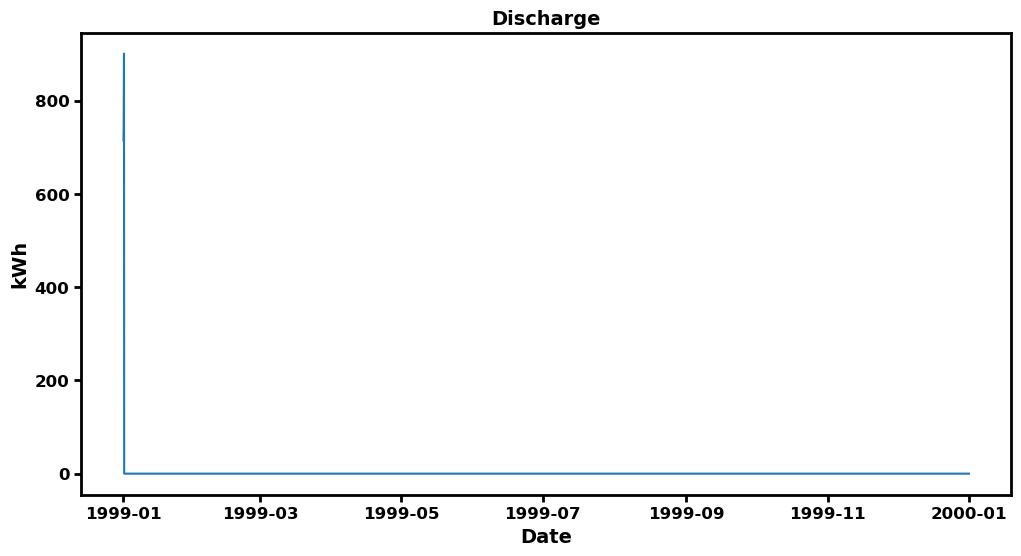

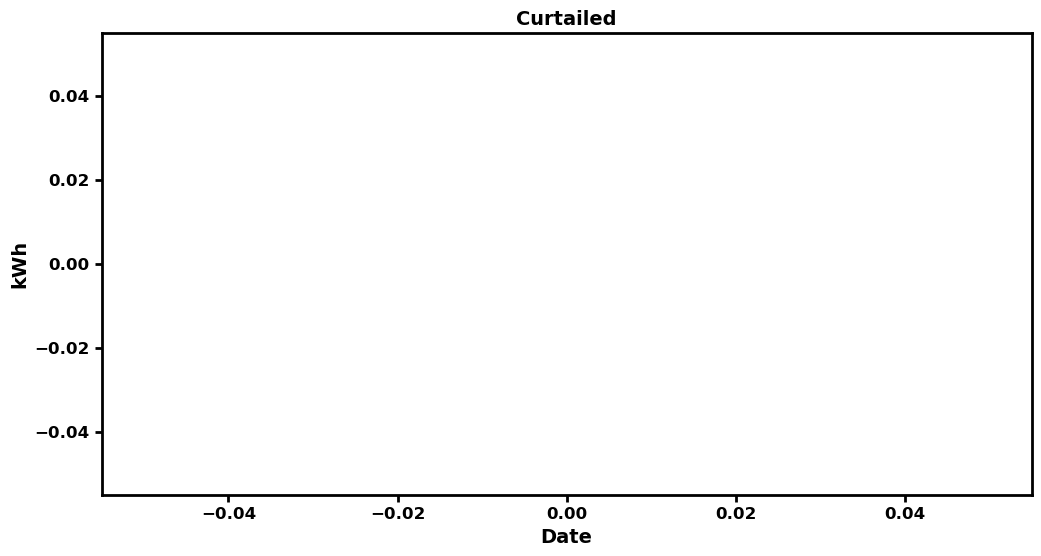

In [15]:
#Plot Battery and Discharge
plt.figure(figsize=(12, 6))
plt.plot(battery_data, label='Battery')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Battery')

plt.figure(figsize=(12, 6))
plt.plot(discharge_data, label='Discharge')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Discharge')

#plot curtailed
plt.figure(figsize=(12, 6))
plt.plot(curtailed, label='Curtailed')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Curtailed')


Text(0, 0.5, 'kWh')

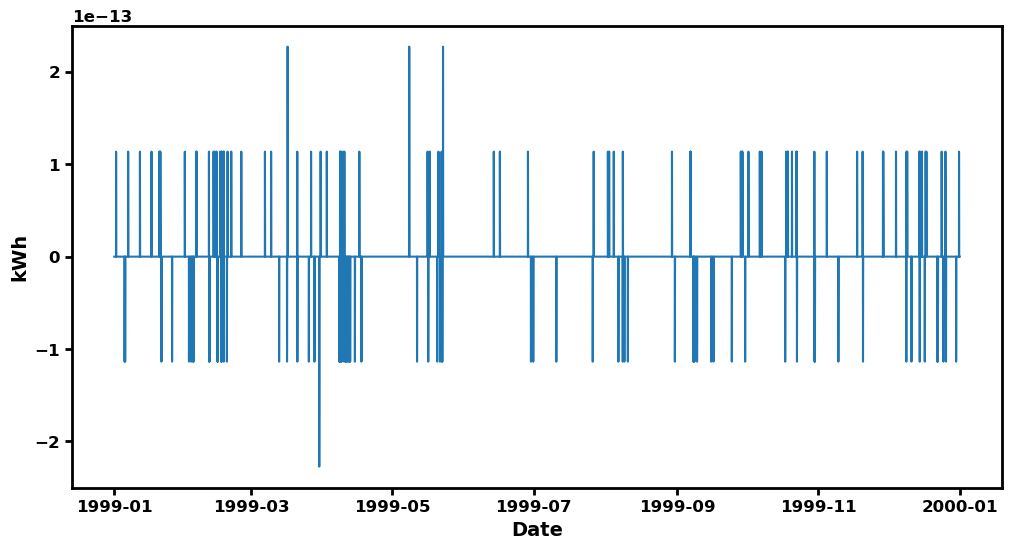

In [16]:
#Plot total supply minus demand
plt.figure(figsize=(12, 6))
plt.plot(supplytotal-demand, label='Supply-Demand')
plt.xlabel('Date')
plt.ylabel('kWh')

In [58]:
#Energy Simulation function w/ Diesel w graphs
def simulate_energyg(turbinenumber, solarcount, nucleargens,battpower, battcap):
    # Your existing code here, with the following modifications:
    
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
    
    # Calculate the supply
    supplyr = wind+solar+nuclear

        #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    curtail = 0
    for i in supplyr-demand:
        if i > 0:
            if i > battpower:
                charge = charge + battpower
                curtail = i-battpower
            else:
                charge = charge + i
                curtail = 0 
            if charge > battcap:
                curtail = curtail + charge - battcap
                charge = battcap
            battery.append(charge)
            discharge.append(0)
            curtailed.append(curtail)
        else:
            if i < -battpower:
                charge = charge - battpower
                if charge <= 0:
                    discharge.append(charge + battpower)
                    charge = 0
                else:
                    discharge.append(battpower)
            else:
                charge = charge + i
                if charge <= 0:
                    discharge.append(charge-i)
                    charge = 0
                else:
                    discharge.append(-i)
            battery.append(charge)
            curtailed.append(0)
        curtail = 0

    supplyrb = wind + solar + nuclear + discharge
     # Calculate the diesel needed
    diesel = []
    fuel = []



    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve
    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    count = -1
    for i in supplyrb-demand:
        count = count+1
        if i > -.0001:
            diesel.append(0)
            fuel.append(0)
        else:
            if i > -250:
                diesel.append(250)
                opcap = 500
                fuel.append(galcalc(opcap, 250))
            elif i > -500:
                diesel.append(-i)
                opcap = 500
                fuel.append(galcalc(opcap, -i))
                
            elif i > -750:
                opcap = 750
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            elif i > -1200:
                opcap = 1200
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            else:
                opcap = 1700
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
        if diesel[-1] + i > 0 and diesel[-1] != 0:
            curtailed[count] = diesel[-1] + i
            
    supplytotal = wind + solar + nuclear + diesel + discharge

    #round the data below to two decimal places
    diesel_data = pd.DataFrame(sim_data.index)
    diesel_data['kWh'] = diesel
    diesel_data.set_index('Date', inplace = True)
    diesel_data = diesel_data.round(2)


    #repeat with fuel 
    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #make fuel data cumulative
    fuel_data['cumulative'] = fuel_data['gal'].cumsum()

        
  
    
    # Create the battery DataFrame
    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)

    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    
    # Plot the diesel data
    plt.figure(figsize=(12, 6))
    plt.plot(diesel_data, label='Diesel')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Diesel')
    

    #plot cumulutive fuel data
    plt.figure(figsize=(12, 6))
    plt.plot(fuel_data['cumulative'], label='Cumulative Fuel')
    plt.xlabel('Date')
    plt.ylabel('Gallons')
    plt.title('Cumulative Fuel')


    # # Plot the total supply minus demand
    # plt.figure(figsize=(12, 6))
    # plt.plot(supplytotal-demand, label='Supply-Demand')
    # plt.xlabel('Date')
    # plt.ylabel('kWh')
    return fuel_data['gal'].sum()

In [18]:
#Energy Simulation function w/ Diesel 
def simulate_energy(turbinenumber, solarcount, nucleargens,battpower, battcap):
    # Your existing code here, with the following modifications:
    
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
    
    # Calculate the supply
    supplyr = wind+solar+nuclear

        #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    curtail = 0
    for i in supplyr-demand:
        if i > 0:
            if i > battpower:
                charge = charge + battpower
                curtail = i-battpower
            else:
                charge = charge + i
                curtail = 0 
            if charge > battcap:
                curtail = curtail + charge - battcap
                charge = battcap
            battery.append(charge)
            discharge.append(0)
            curtailed.append(curtail)
        else:
            if i < -battpower:
                charge = charge - battpower
                if charge <= 0:
                    discharge.append(charge + battpower)
                    charge = 0
                else:
                    discharge.append(battpower)
            else:
                charge = charge + i
                if charge <= 0:
                    discharge.append(charge-i)
                    charge = 0
                else:
                    discharge.append(-i)
            battery.append(charge)
            curtailed.append(0)
        curtail = 0

    supplyrb = wind + solar + nuclear + discharge
     # Calculate the diesel needed
    diesel = []
    fuel = []



    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve
    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    for i in supplyrb-demand:
        if i > 0:
            diesel.append(0)
            fuel.append(0)
        else:
            if i > -250:
                diesel.append(250)
                opcap = 500
                fuel.append(galcalc(opcap, 250))
            elif i > -500:
                diesel.append(-i)
                opcap = 500
                fuel.append(galcalc(opcap, -i))
                
            elif i > -750:
                opcap = 750
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            elif i > -1200:
                opcap = 1200
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            else:
                opcap = 1700
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
    supplytotal = wind + solar + nuclear + diesel + discharge
    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #return the total amount of fuel used
    return fuel_data['gal'].sum()
    

In [19]:
#Energy Simulation Function no Diesel
def simulate_energynod(turbinenumber, solarcount, nucleargens,battpower, battcap):
    # Your existing code here, with the following modifications:
    
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
    
    # Calculate the supply
    supplyr = wind+solar+nuclear
    
  
    
    supplytotal = wind + solar + nuclear
   
    
    # Calculate the battery charge
    #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    curtail = 0
    for i in supplytotal-demand:
        if i > 0:
            if i > battpower:
                charge = charge + battpower
                curtail = i-battpower
            else:
                charge = charge + i
                curtail = 0 
            if charge > battcap:
                curtail = curtail + charge - battcap
                charge = battcap
            battery.append(charge)
            discharge.append(0)
            curtailed.append(curtail)
        else:
            if i < -battpower:
                charge = charge - battpower
                if charge <= 0:
                    discharge.append(charge + battpower)
                    charge = 0
                else:
                    discharge.append(battpower)
            else:
                charge = charge + i
                if charge <= 0:
                    discharge.append(charge-i)
                    charge = 0
                else:
                    discharge.append(-i)
            battery.append(charge)
            curtailed.append(0)
        curtail = 0
    
       # Calculate the total supply
    supplytotal = wind + solar + nuclear + discharge
    # Create the battery DataFrame
    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)

    # # Plot the battery data
    # plt.figure(figsize=(12, 6))
    # plt.plot(battery_data, label='Battery')
    # plt.xlabel('Date')
    # plt.ylabel('kWh')
    # plt.title('Battery')

    #  # Plot the discharge data
    # plt.figure(figsize=(12, 6))
    # plt.plot(discharge_data, label='Discharge')
    # plt.xlabel('Date')
    # plt.ylabel('kWh')
    # plt.title('Discharge')
    
    # # Plot the total supply minus demand
    # plt.figure(figsize=(12, 6))
    # plt.plot(supplytotal-demand, label='Supply-Demand')
    # plt.xlabel('Date')
    # plt.ylabel('kWh')
    # plt.title('Excess Supply')
    count = 0
    for s, d in zip(supplytotal, demand):
        if s >= d:
            count += 1
    return count
    # Return number of hours with unsatisfied demand

In [20]:
#Energy Simulation Function no Diesel w/graphs
def simulate_energynodg(turbinenumber, solarcount, nucleargens,battpower, battcap):
    # Your existing code here, with the following modifications:
    
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
    
    # Calculate the supply
    supplyr = wind+solar+nuclear
    
  
    
    supplytotal = wind + solar + nuclear
   
    
    #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    curtail = 0
    for i in supplytotal-demand:
        if i > 0:
            if i > battpower:
                charge = charge + battpower
                curtail = i-battpower
            else:
                charge = charge + i
                curtail = 0 
            if charge > battcap:
                curtail = curtail + charge - battcap
                charge = battcap
            battery.append(charge)
            discharge.append(0)
            curtailed.append(curtail)
        else:
            if i < -battpower:
                charge = charge - battpower
                if charge <= 0:
                    discharge.append(charge + battpower)
                    charge = 0
                else:
                    discharge.append(battpower)
            else:
                charge = charge + i
                if charge <= 0:
                    discharge.append(charge-i)
                    charge = 0
                else:
                    discharge.append(-i)
            battery.append(charge)
            curtailed.append(0)
        curtail = 0
    
       # Calculate the total supply
    supplytotal = wind + solar + nuclear + discharge
    # Create the battery DataFrame
    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)


    # Plot the battery data
    plt.figure(figsize=(12, 6))
    plt.plot(battery_data, label='Battery')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Battery')

     # Plot the discharge data
    plt.figure(figsize=(12, 6))
    plt.plot(discharge_data, label='Discharge')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Discharge')
    
    # Plot the total supply minus demand
    plt.figure(figsize=(12, 6))
    plt.plot(supplytotal-demand, label='Supply-Demand')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Excess Supply')

    #plot the curtailed data
    plt.figure(figsize=(12, 6))
    plt.plot(curtailed_data, label='Curtailed')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Curtailed')

    count = 0
    
    #plot these graphsagain but for a set of two days in summer rather than the entire dataset
    #select the two days


    #plot the battery
    plt.figure(figsize=(12, 6))
    plt.plot(battery_data['1999-07-01':'1999-07-08'], label='Battery')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Battery Summer Days')

    #plot the discharge
    plt.figure(figsize=(12, 6))
    plt.plot(discharge_data['1999-07-01':'1999-07-08'], label='Discharge')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Discharge Summer Days')
    
    #plot the excess supply
    plt.figure(figsize=(12, 6))
    plt.plot(supplytotal['1999-07-01':'1999-07-08']-demand['1999-07-01':'1999-07-08'], label='Supply-Demand')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Excess Supply Summer Days')

    #plot the curtailed
    plt.figure(figsize=(12, 6))
    plt.plot(curtailed_data['1999-07-01':'1999-07-08'], label='Curtailed')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Curtailed Summer Days')


    for s, d in zip(supplytotal, demand):
        if s >= d:
            count += 1
    return count
    # Return number of hours with unsatisfied demand

In [103]:
#Energy Simulation For Scenarios
#Energy Simulation function w/ Diesel 
def simulate_energyscenario(turbinenumber, solarcount, nucleargens,battpower, battcap):
    # Your existing code here, with the following modifications:
    
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
    
    # Calculate the supply
    supplyr = wind+solar+nuclear

        #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    curtail = 0
    for i in supplyr-demand:
        if i > 0:
            if i > battpower:
                charge = charge + battpower
                curtail = i-battpower
            else:
                charge = charge + i
                curtail = 0 
            if charge > battcap:
                curtail = curtail + charge - battcap
                charge = battcap
            battery.append(charge)
            discharge.append(0)
            curtailed.append(curtail)
        else:
            if i < -battpower:
                charge = charge - battpower
                if charge <= 0:
                    discharge.append(charge + battpower)
                    charge = 0
                else:
                    discharge.append(battpower)
            else:
                charge = charge + i
                if charge <= 0:
                    discharge.append(charge-i)
                    charge = 0
                else:
                    discharge.append(-i)
            battery.append(charge)
            curtailed.append(0)
        curtail = 0

    supplyrb = wind + solar + nuclear + discharge
     # Calculate the diesel needed
    diesel = []
    fuel = []

    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve
    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    count = -1
    for i in supplyrb-demand:
        count = count+1
        if i > -.001:
            diesel.append(0)
            fuel.append(0)
        else:
            if i > -250:
                diesel.append(250)
                opcap = 500
                fuel.append(galcalc(opcap, 250))
            elif i > -500:
                diesel.append(-i)
                opcap = 500
                fuel.append(galcalc(opcap, -i))
                
            elif i > -750:
                opcap = 750
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            elif i > -1200:
                opcap = 1200
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
            else:
                opcap = 1700
                diesel.append(-i)
                fuel.append(galcalc(opcap, -i))
        if diesel[-1] + i > 0 and diesel[-1] != 0:
            curtailed[count] = diesel[-1] + i
    supplytotal = wind + solar + nuclear + diesel + discharge

    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #make fuel data cumulative
    fuel_data['cumulative'] = fuel_data['gal'].cumsum()

    fuel = np.array(fuel_data['cumulative'])

    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)
    #make curtailed data cumulative
    curtailed_data['cumulative'] = curtailed_data['kWh'].cumsum()
    curtailedcum = np.array(curtailed_data['cumulative'])

    
    #return the total amount of fuel used
    # Create a DataFrame with data for each generation type, fuel usage, and curtailed electricity
    data = pd.DataFrame({
        'Wind': wind,
        'Solar': solar,
        'Nuclear': nuclear,
        'Battery': discharge,
        'Diesel': diesel,
        'Fuel': fuel,  # Assuming fuel is calculated somewhere in your code
        'Curtailed': curtailed,
        'Curtailedcum': curtailedcum
    }, index=sim_data.index)

    #plot fuel
    plt.figure(figsize=(12, 6))
    plt.plot(fuel_data['cumulative'], label='Fuel')
    plt.xlabel('Date')
    plt.ylabel('Gallons')
    plt.title('Fuel')

    #plot curtailed
    plt.figure(figsize=(12, 6))
    plt.plot(curtailed_data['cumulative'], label='Curtailed')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Curtailed')

    #plot discharge
    plt.figure(figsize=(12, 6))
    plt.plot(discharge_data, label='Discharge')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Battery Discharge')

    #plot battery charge
    plt.figure(figsize=(12, 6))
    plt.plot(battery_data, label='Battery')
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Battery Charge')

    #plot all generation stacking (Diesel, Battery, Solar, Wind) on same graph with legend
    plt.figure(figsize=(12, 6))
    colors = ['grey', 'blue', 'yellow', 'green']  # Specify your own colors here
    plt.stackplot(data.index, data['Diesel'], data['Battery'], data['Solar'], data['Wind'], labels=['Diesel', 'Battery', 'Solar', 'Wind'], colors=colors)
    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Generation')
    plt.legend(loc='upper left')
    plt.show()

    #plot all generation stacking (Diesel, Battery, Solar, Wind) on same graph with legend for two summer days
    plt.figure(figsize=(12, 6))
    colors = ['grey', 'blue', 'yellow', 'green']  # Specify your own colors here
    stack_plots = plt.stackplot(data['1999-07-01':'1999-07-08'].index, data['1999-07-01':'1999-07-08']['Diesel'], data['1999-07-01':'1999-07-08']['Battery'], data['1999-07-01':'1999-07-08']['Solar'], data['1999-07-01':'1999-07-08']['Wind'], colors=colors)

    # Add a dotted line that traces demand for the two summer days
    demand_line = plt.plot(demand['1999-07-01':'1999-07-08'], 'k--', label = 'Demand')  # Assuming demand is defined somewhere in your code

    # Calculate total energy for the two summer days
    total_energy = data['1999-07-01':'1999-07-08']['Diesel'] + data['1999-07-01':'1999-07-08']['Battery'] + data['1999-07-01':'1999-07-08']['Solar'] + data['1999-07-01':'1999-07-08']['Wind']

    # Shade the area between the stacked plot and the curtailed line
    curtailed_fill = plt.fill_between(data['1999-07-01':'1999-07-08'].index, total_energy, total_energy - data['1999-07-01':'1999-07-08']['Curtailed'], color='red', alpha=0.5, hatch='///')
    curtailed_patch = mpatches.Patch(color='red', alpha=0.5, hatch='///', label='Curtailed Energy')

    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.title('Generation')

    # Create the first legend and add it to the plot
    first_legend = plt.legend(stack_plots[::-1], ['Diesel', 'Battery', 'Solar', 'Wind'][::-1], loc='upper left')
    plt.gca().add_artist(first_legend)

    # Create the second legend and add it to the plot
    plt.legend([demand_line[0], curtailed_patch], ['Demand', 'Curtailed Energy'], loc='upper right')       
    plt.show()
    

    return data
    
   
    # Return number of hours with unsatisfied demand

Total diesel used: 97877.92 kWh


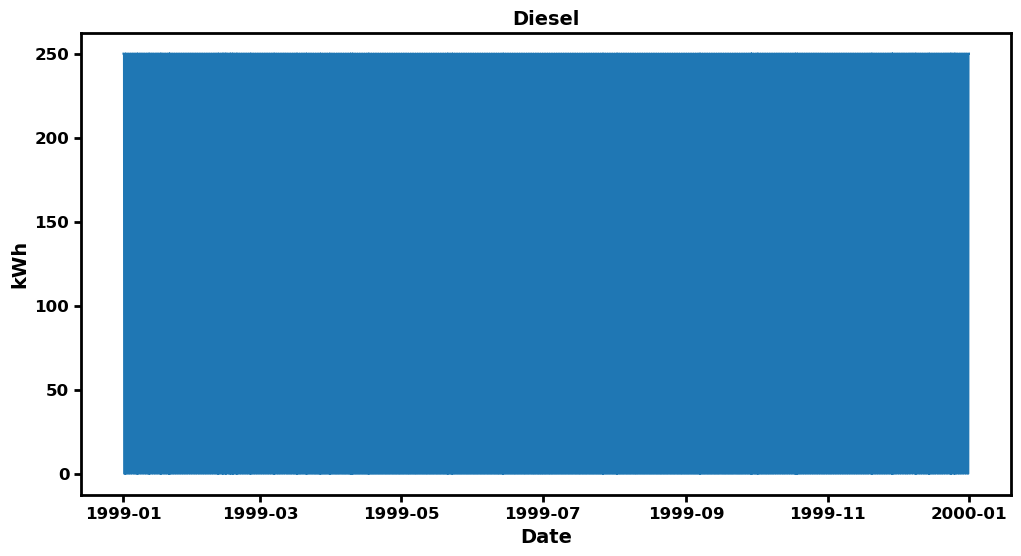

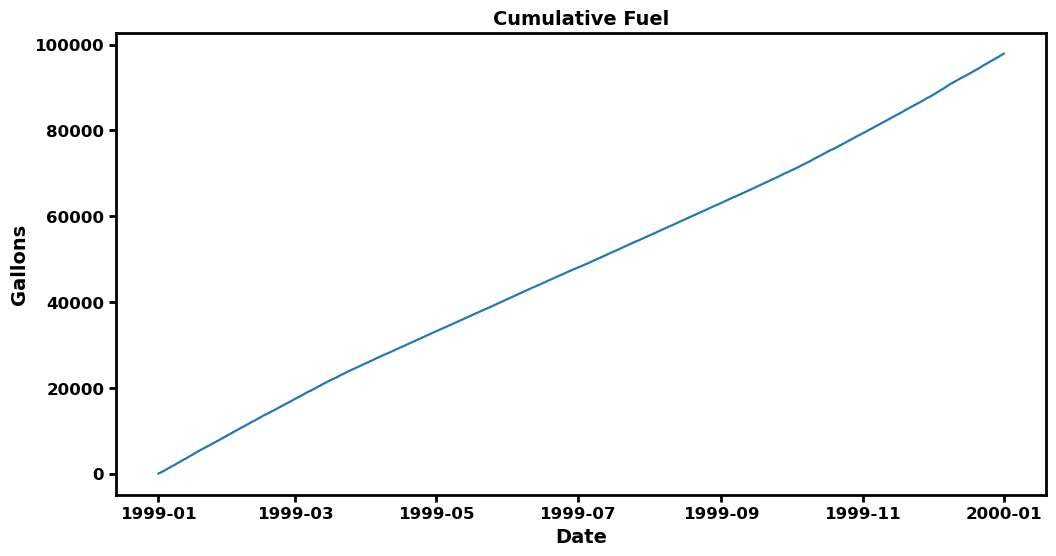

In [45]:
#Diesel simulation tests
dieselwind = simulate_energyg(1, 48500, 0, 2000, 15000)
print(f'Total diesel used: {dieselwind} kWh')

# # %%
# diesel = simulate_energy(0, 0, 0,50)
# print(f'Total diesel used: {diesel} kWh')

# # %%
# dieselsolar = simulate_energy(0, 100, 0,50)
# print(f'Total diesel used: {dieselsolar} kWh')

# # %%
# dieselnuclear = simulate_energy(0, 0, 1,50)
# print(f'Total diesel used: {dieselnuclear} kWh')

8760

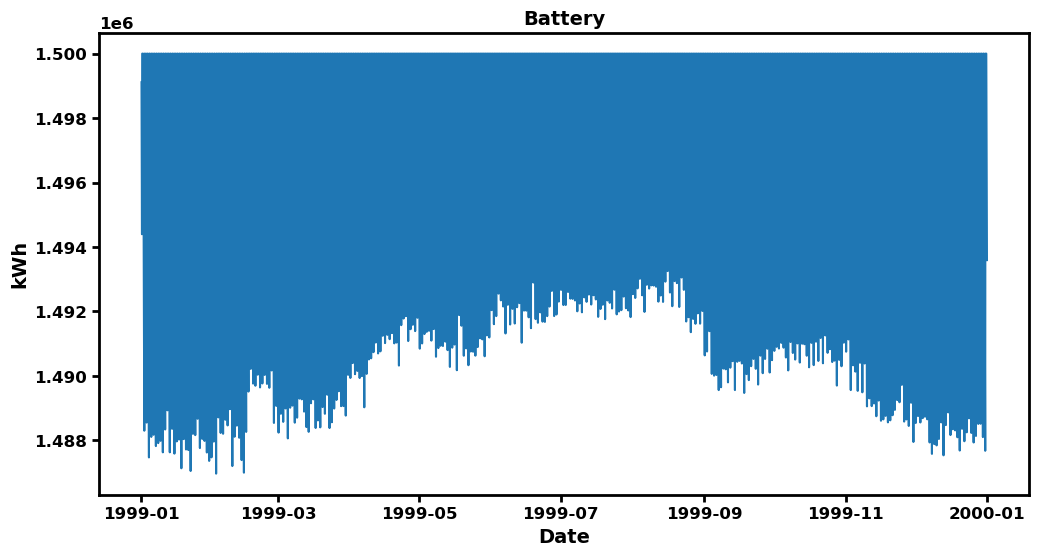

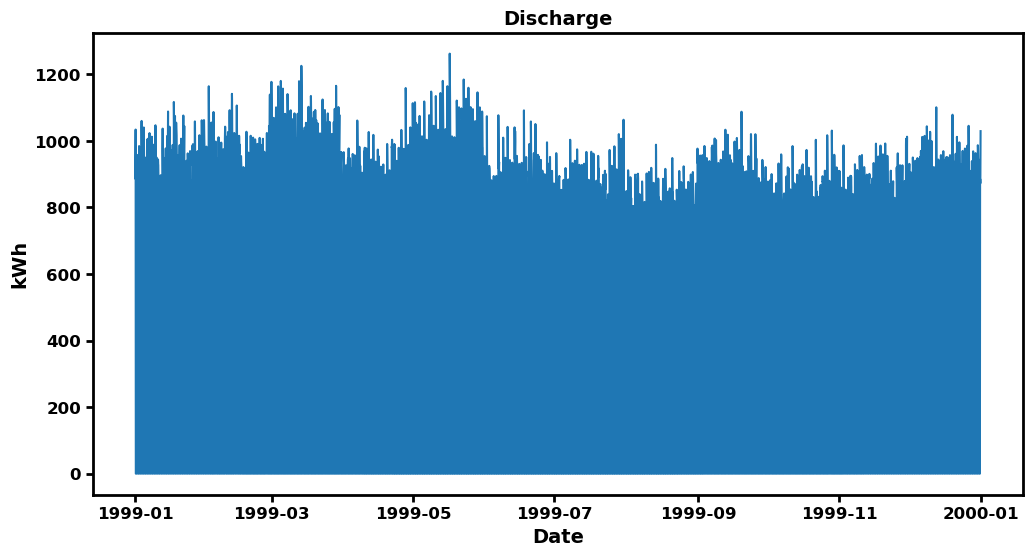

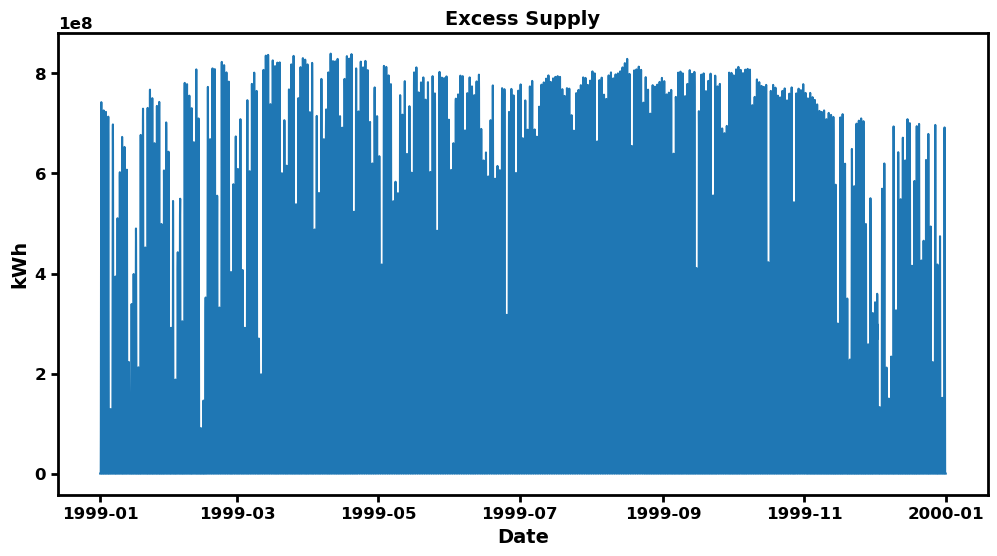

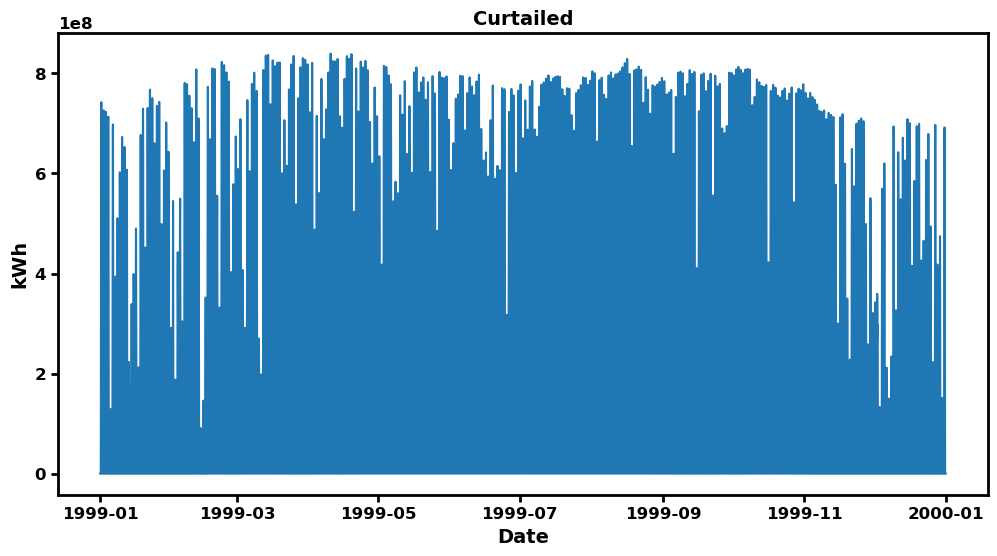

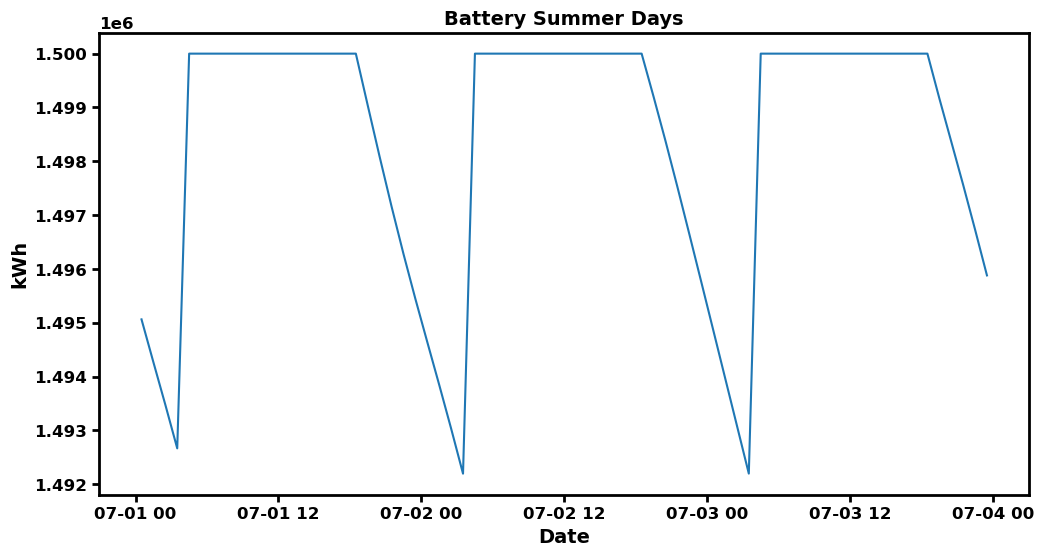

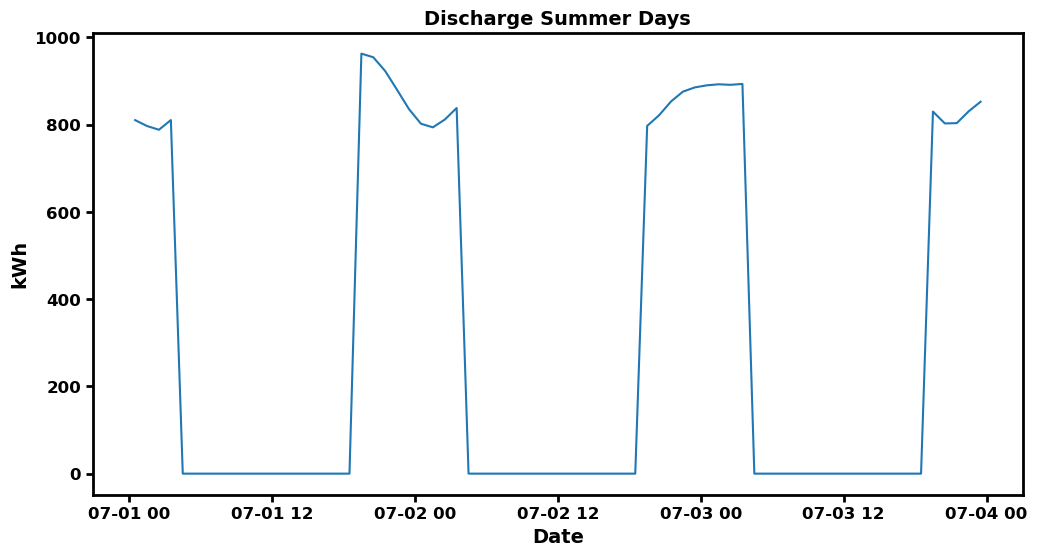

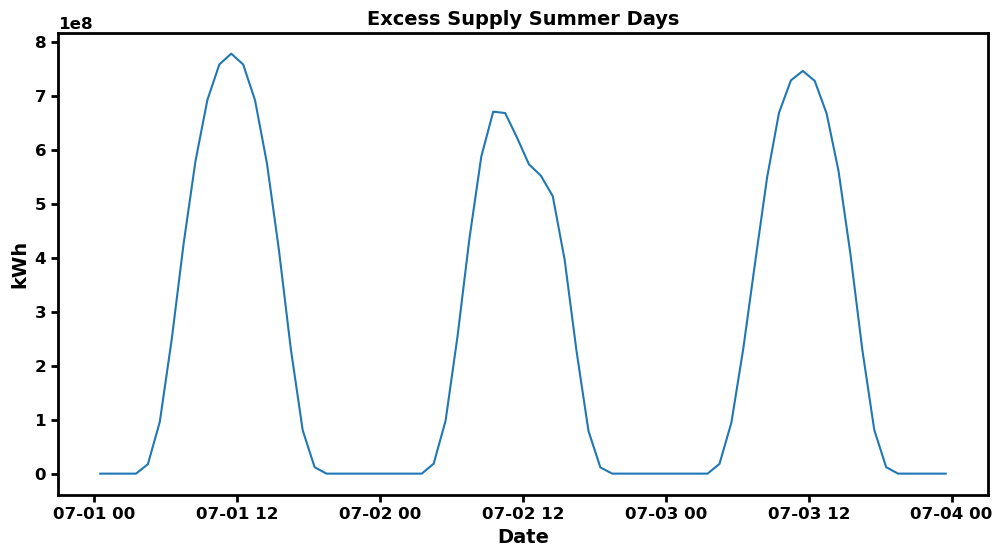

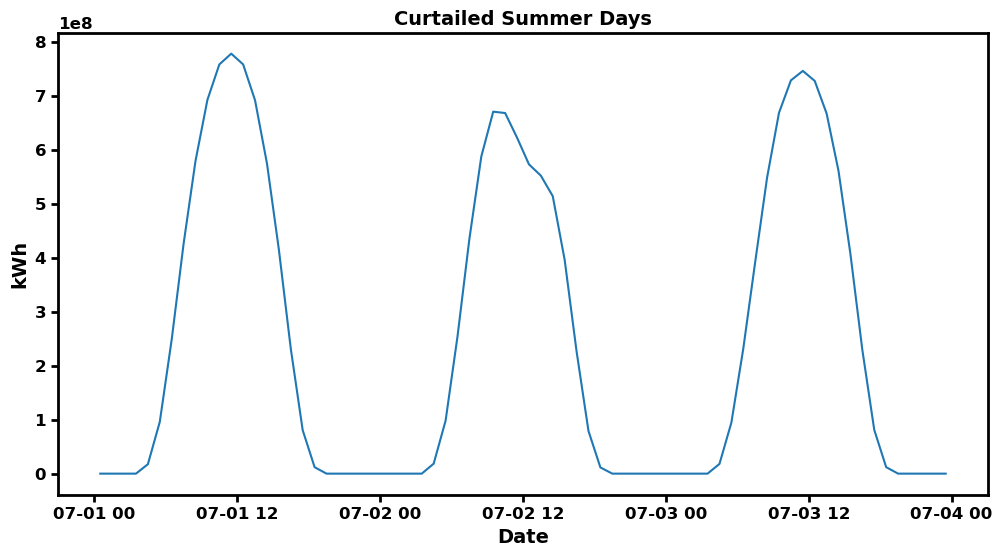

In [ ]:
#No Diesel Simulation Tests
#onlysolar = simulate_energynodg(0, 100000000000, 0,8000)
simulate_energynodg(0, 1000000000, 0,100000,1500000)
# print(f'Total unsatisfied demand: {onlysolar} hours')
#with infinitie solar panels and no battery 4309 hours unsatisfied
#with infinite solar panels, youd need appx 8 MWh battery
#  onlywind = simulate_energynod(20000000000, 0, 0,0)
#  print(f'Total unsatisfied demand: {onlywind} kWh')
# # With infinite wind turbines and no battery 1516 hours unsatisfied
# # With infinite solar 50 MWh battery 
# hybridwindsolar = simulate_energynod(100000000000, 10000000000, 0, 8000)
# print(f'Total unsatisfied demand: {hybridwindsolar} kWh')
# #With infinite wind and solar panels 8MWh satisfies all demand

Below are where we make graphs to identify renewable interests

13050


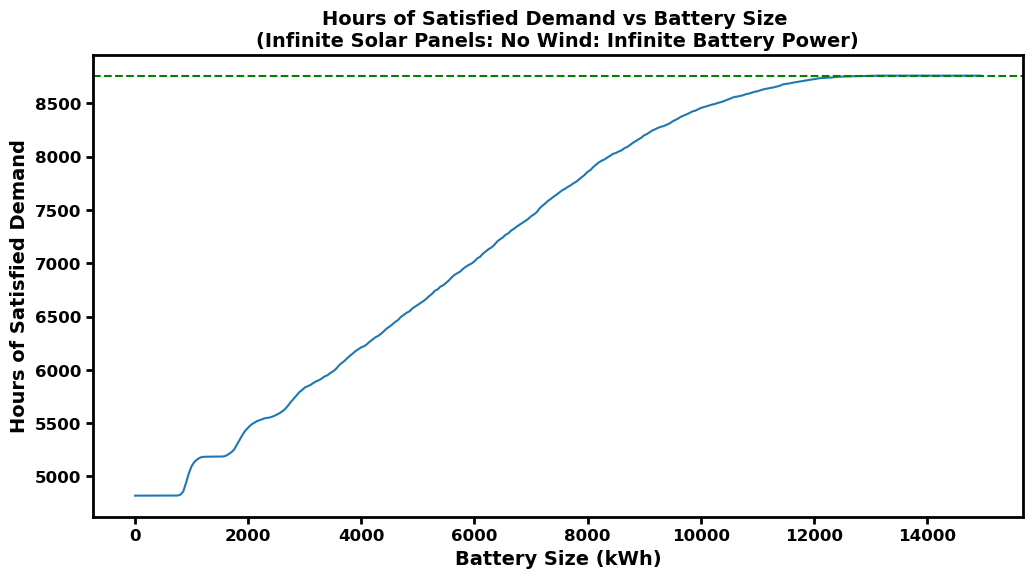

In [ ]:
#Battery capacity Sizing Infinite Solar
battsize = np.arange(0, 15000, 50)
hours = []
for i in battsize:
    hours.append(simulate_energynod(0, 10000000000, 0,1000000000, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size \n(Infinite Solar Panels: No Wind: Infinite Battery Power)')
#textbox that says the max hours of demand satisfied
#plt.text(10000, 16000, f'All Demand Statasfied: {battsize[hours.index(max(hours))]}')
#draw a flat green line at the total number of hours of demand
plt.axhline(y=len(sim_data), color='g', linestyle='--')
#print first value where hours is maxed 
print(battsize[hours.index(max(hours))])


(12000.0, 15000.0)

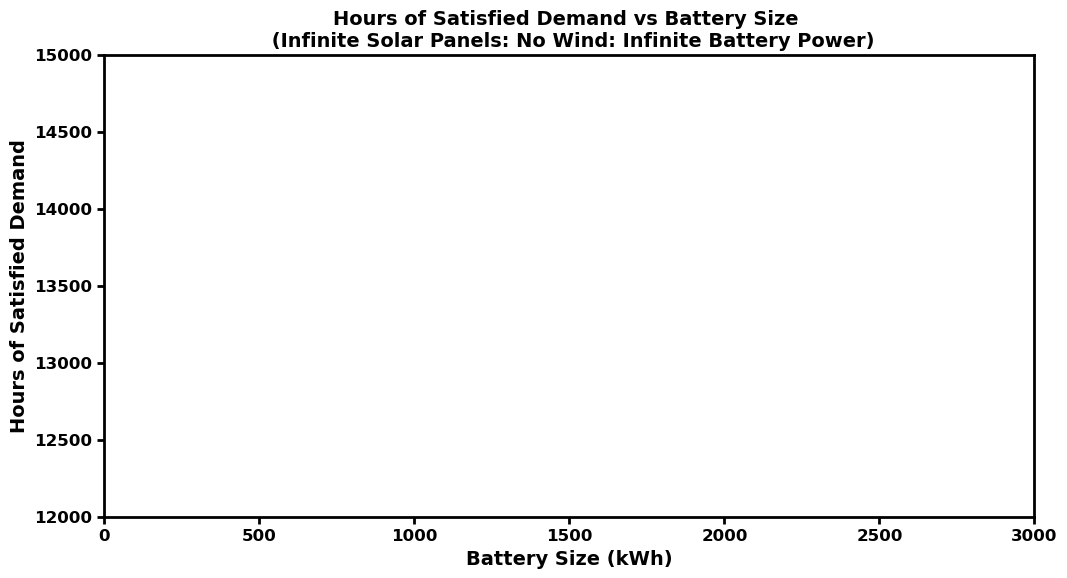

In [ ]:
#Zoom 1
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size \n (Infinite Solar Panels: No Wind: Infinite Battery Power)')
plt.xlim(0, 3000)
plt.ylim(12000, 15000)

1300


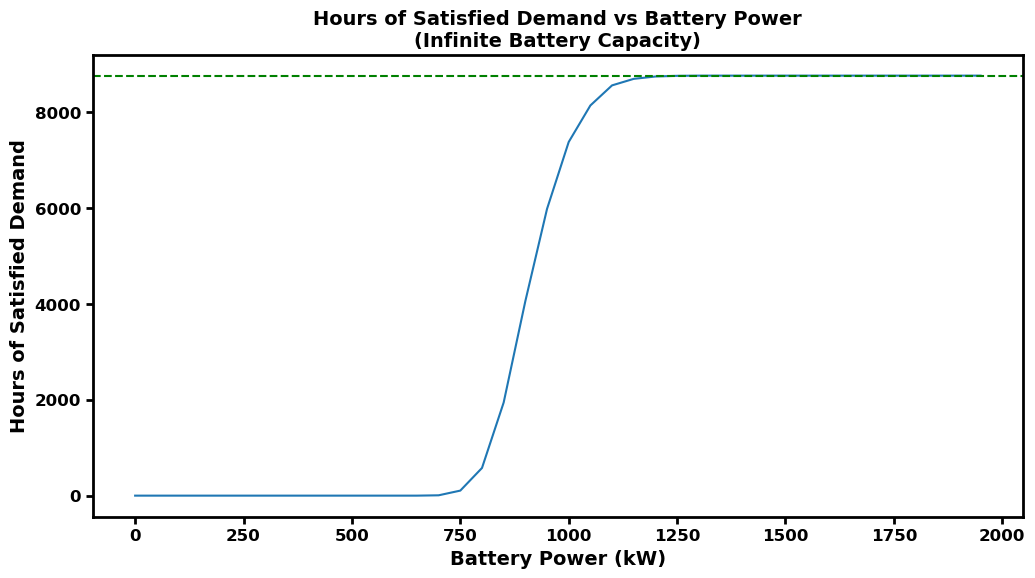

In [ ]:
#Battery Power Sizing 
battsize = np.arange(0, 2000, 50)
hours = []
for i in battsize:
    hours.append(simulate_energynod(0, 0, 0, i , 10000000000000000000))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Power (kW)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Power\n(Infinite Battery Capacity)')
#textbox that says the max hours of demand satisfied
#plt.text(10000, 16000, f'All Demand Statasfied: {battsize[hours.index(max(hours))]}')
#draw a flat green line at the total number of hours of demand
plt.axhline(y=len(sim_data), color='g', linestyle='--')
#print first value where hours is maxed 
print(battsize[hours.index(max(hours))])
#1450

147000


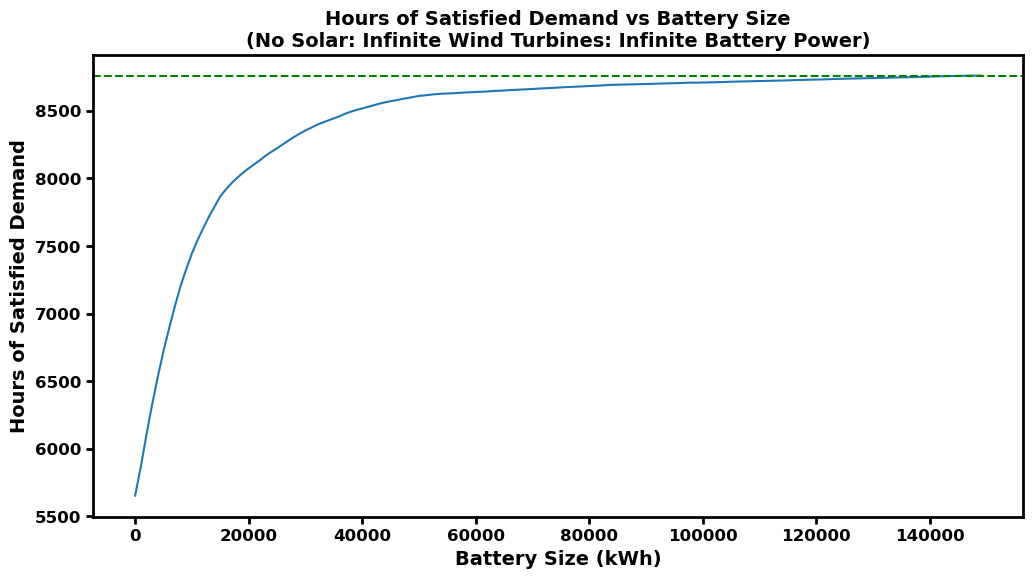

In [ ]:
#Battery Sizing Infinite Wind
battsize = np.arange(0, 150000, 1000)
hours = []
for i in battsize:
    hours.append(simulate_energynod(100000000000, 0, 0,1000000000, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size\n(No Solar: Infinite Wind Turbines: Infinite Battery Power)')
#draw a flat green line at the total number of hours of demand
plt.axhline(y=len(sim_data), color='g', linestyle='--')
#print first value where hours is maxed
print(battsize[hours.index(max(hours))])
#145000 kWh battery satisfies all demand

(14000.0, 16000.0)

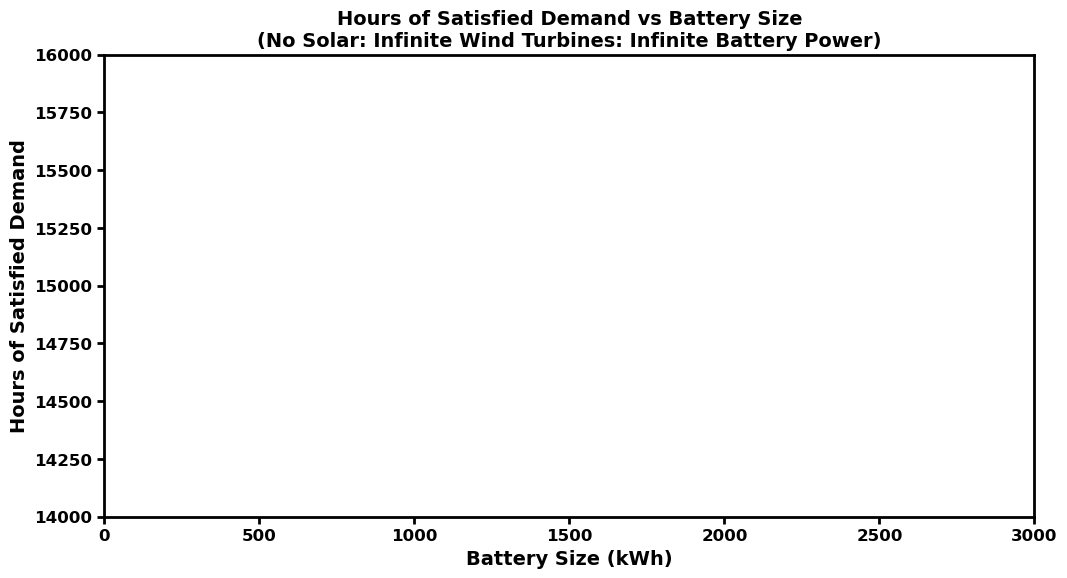

In [ ]:
#Zoom 1
#Battery Sizing Infinite Wind
battsize = np.arange(0, 5000, 50)
hours = []
for i in battsize:
    hours.append(simulate_energynod(100000000000, 0, 0,1000000000, i))
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size\n(No Solar: Infinite Wind Turbines: Infinite Battery Power)')
plt.xlim(0, 3000)
plt.ylim(14000, 16000)

12550


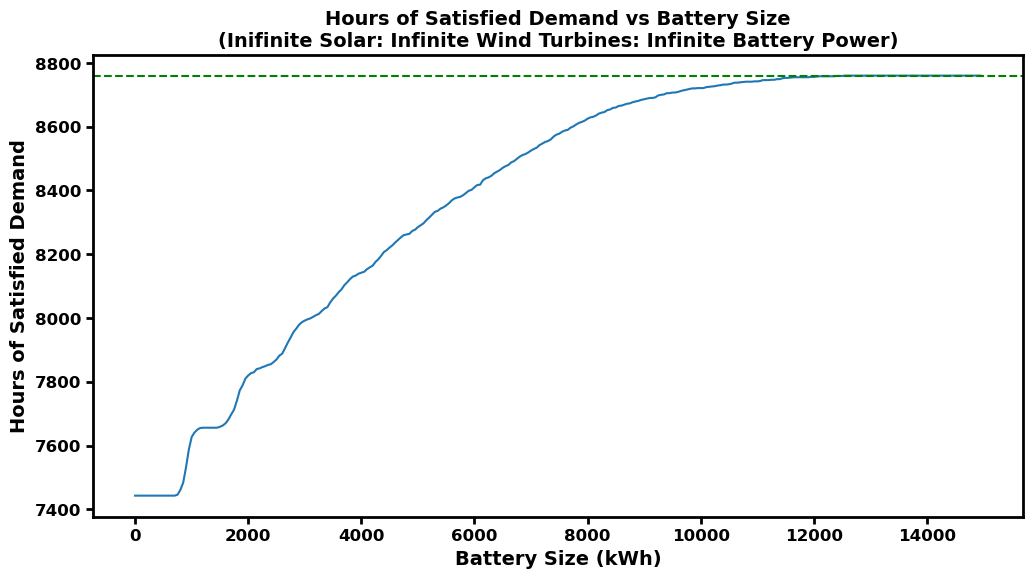

In [ ]:
#Battery Sizing Both Infinite
battsize = np.arange(0, 15000, 50)
hours = []
for i in battsize:
    hours.append(simulate_energynod(10000000000, 10000000000, 0,10000000000,i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size\n(Inifinite Solar: Infinite Wind Turbines: Infinite Battery Power)')
#draw a flat green line at the total number of hours of demand
plt.axhline(y=len(sim_data), color='g', linestyle='--')

print(battsize[hours.index(max(hours))])
#14000 kWh battery satisfies all demand

(18500.0, 20500.0)

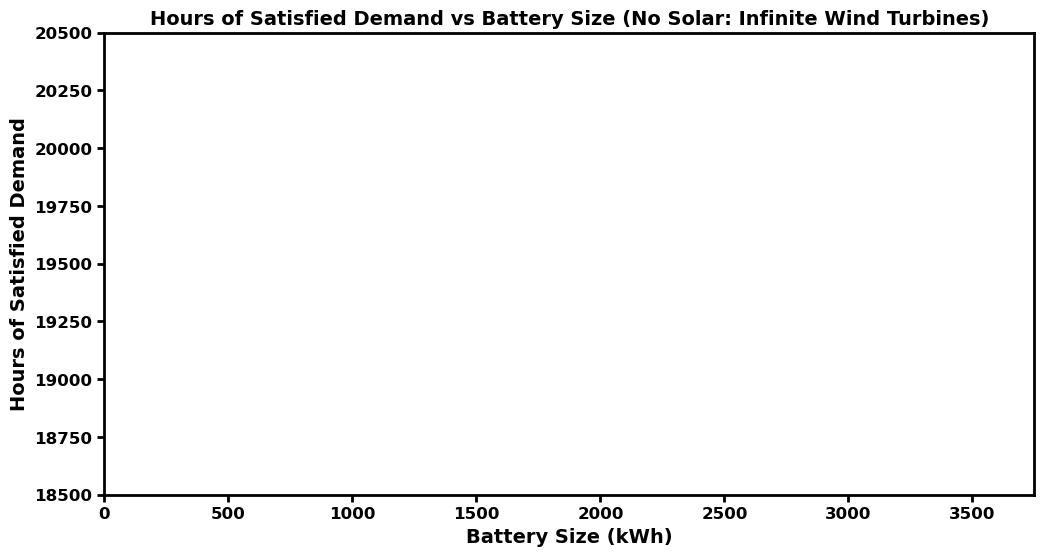

In [ ]:
# Zoom 1
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Battery Size (No Solar: Infinite Wind Turbines)')
plt.xlim(0, 3750)
plt.ylim(18500, 20500)

39500


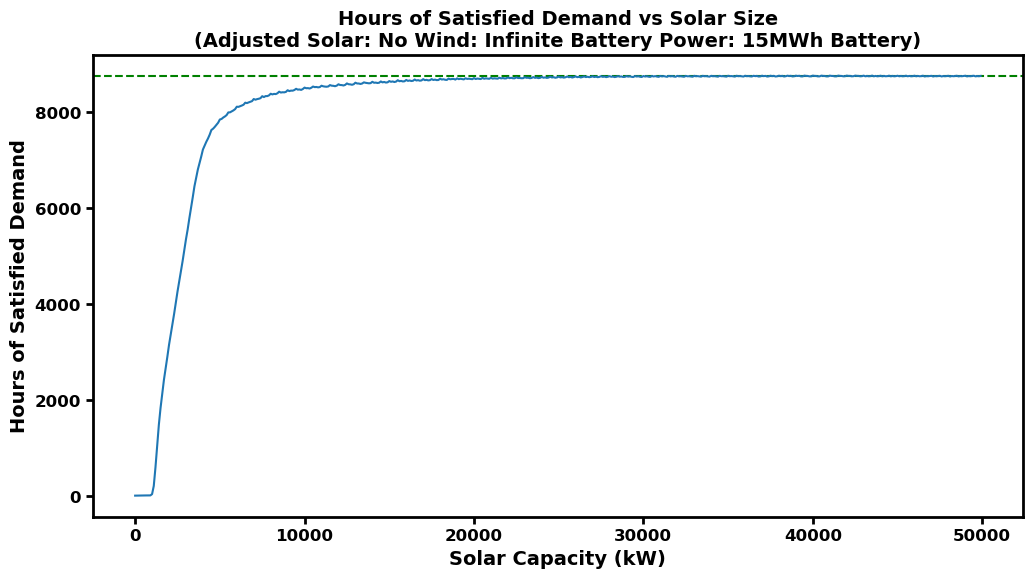

In [ ]:
#Solar Sizing, constant Battery
solsize = np.arange(0, 50000, 100)
hours = []
for i in solsize:
    hours.append(simulate_energynod(0, i, 0,10000000, 15000))
#plot the data
plt.figure(figsize=(12, 6))
plt.axhline(y=len(sim_data), color='g', linestyle='--')
plt.plot(solsize, hours)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Solar Size\n(Adjusted Solar: No Wind: Infinite Battery Power: 15MWh Battery)')
#draw a flat green line at the total number of hours of demand
#print first value where hours is maxed
print(solsize[hours.index(max(hours))])
#48500

Text(0.5, 1.0, 'Hours of Satisfied Demand vs Solar Size\n(Adjusted Solar: No Wind: Infinite Battery Power: 15MWh Battery)')

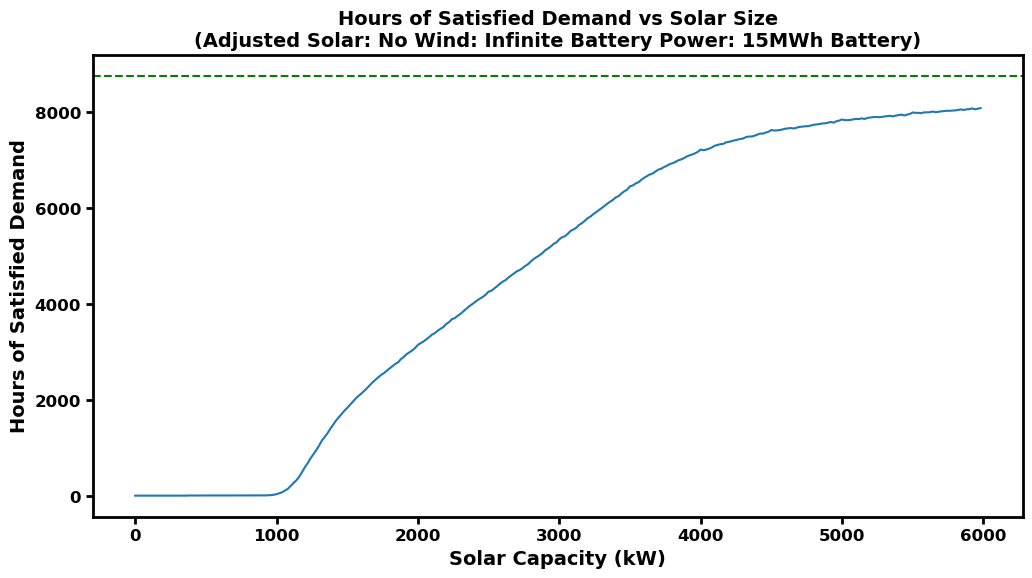

In [ ]:
#Zoom 1
#Solar Sizing, constant Battery
solsize = np.arange(0, 6000, 20)
hours = []
for i in solsize:
    hours.append(simulate_energynod(0, i, 0,10000000, 15000))
#plot the data
plt.figure(figsize=(12, 6))
plt.axhline(y=len(sim_data), color='g', linestyle='--')
plt.plot(solsize, hours)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Solar Size\n(Adjusted Solar: No Wind: Infinite Battery Power: 15MWh Battery)')
#draw a flat green line at the total number of hours of demand


500


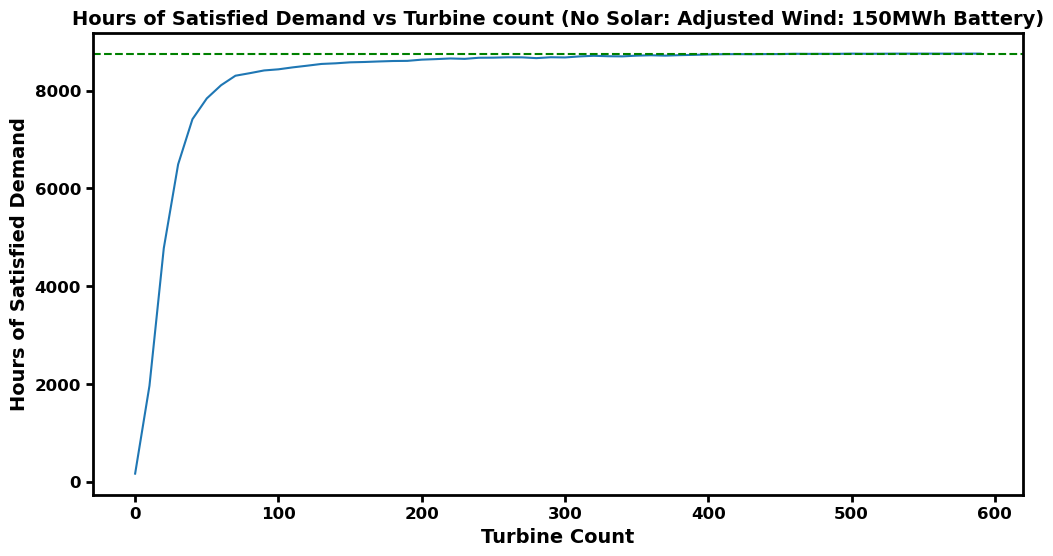

In [ ]:
# Wind Sizing, Constant Battery
windsize = np.arange(0, 600, 10)
hours = []
for i in windsize:
    hours.append(simulate_energynod(i, 0, 0,10000000, 150000))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(windsize, hours)
plt.xlabel('Turbine Count')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Turbine count (No Solar: Adjusted Wind: 150MWh Battery)')
#draw a flat green line at the total number of hours of demand
plt.axhline(y=len(sim_data), color='g', linestyle='--')
#print first value where hours is maxed
print(windsize[hours.index(max(hours))])

(0.0, 8000.0)

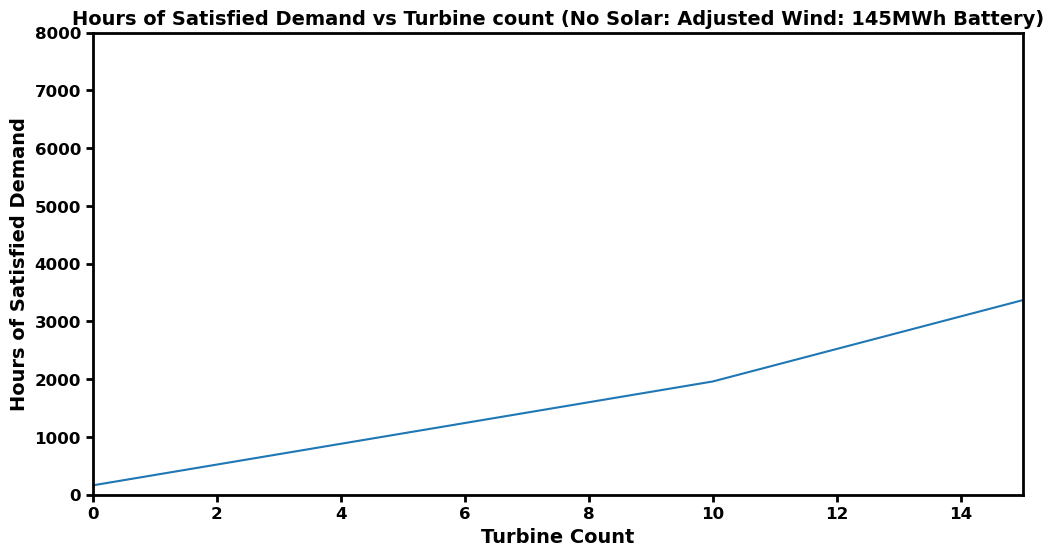

In [ ]:
#Zoom 1
plt.figure(figsize=(12, 6))
plt.plot(windsize, hours)
plt.xlabel('Turbine Count')
plt.ylabel('Hours of Satisfied Demand')
plt.title('Hours of Satisfied Demand vs Turbine count (No Solar: Adjusted Wind: 145MWh Battery)')
plt.xlim(0, 15)
plt.ylim(0,8000)

In [ ]:
#3d graph, solar wind hybrid sizing, constant battery
import plotly.graph_objects as go

X = np.arange(0, 10000, 100)
Y = np.arange(0, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([simulate_energynod(y, x, 0,10000,20000) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='RdYlGn')])

fig.update_layout(title='Hours of Satisfied Demand vs Solar and Wind Capacity (15MWh Battery)', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.update_layout(scene = dict(
                    xaxis_title='Solar Capacity (kW)',
                    yaxis_title='Turbine Count',
                    zaxis_title='Hours of Satisfied Demand'))

fig.show()



# Fuel Savings Analysis

281322.94


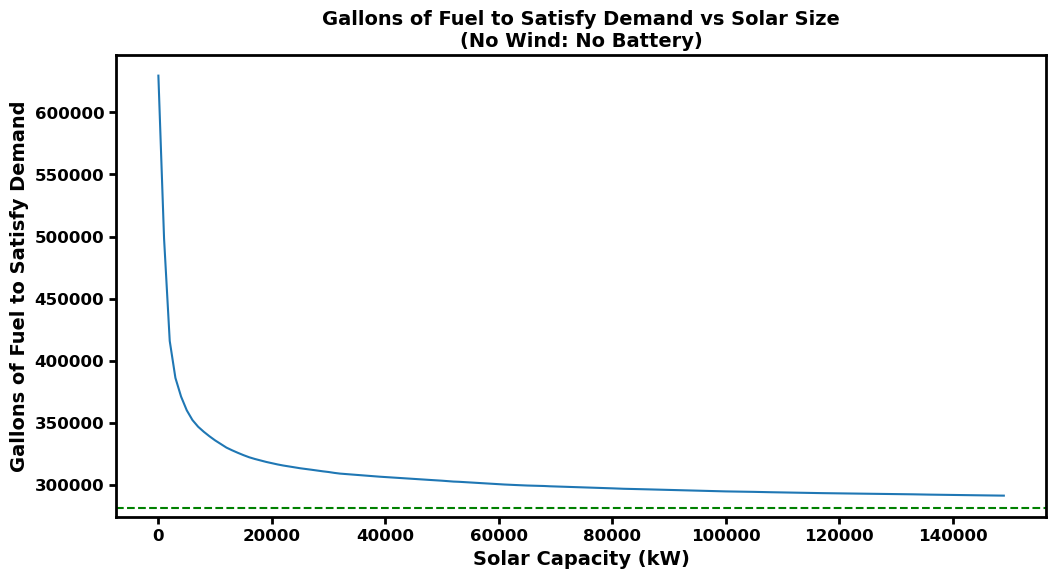

In [ ]:
#Solar, No wind, No Battery
solsize = np.arange(0, 150000, 1000)
fdem = []
for i in solsize:
    fdem.append(simulate_energy(0, i, 0,0, 0))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Solar Size\n(No Wind: No Battery)')

#return what value when fuel is minimized
#print the last 5 values
#find limit and draw line at horizontal limit
aymp = simulate_energy(0,1000000000000000,0,0,0)
print(aymp)
plt.axhline(y=aymp, color='g', linestyle='--')


#max 1,524,000
#min 670,000 


Text(0.5, 1.0, 'Gallons of Fuel to Satisfy Demand vs Solar Size\n(No Wind: No Battery)')

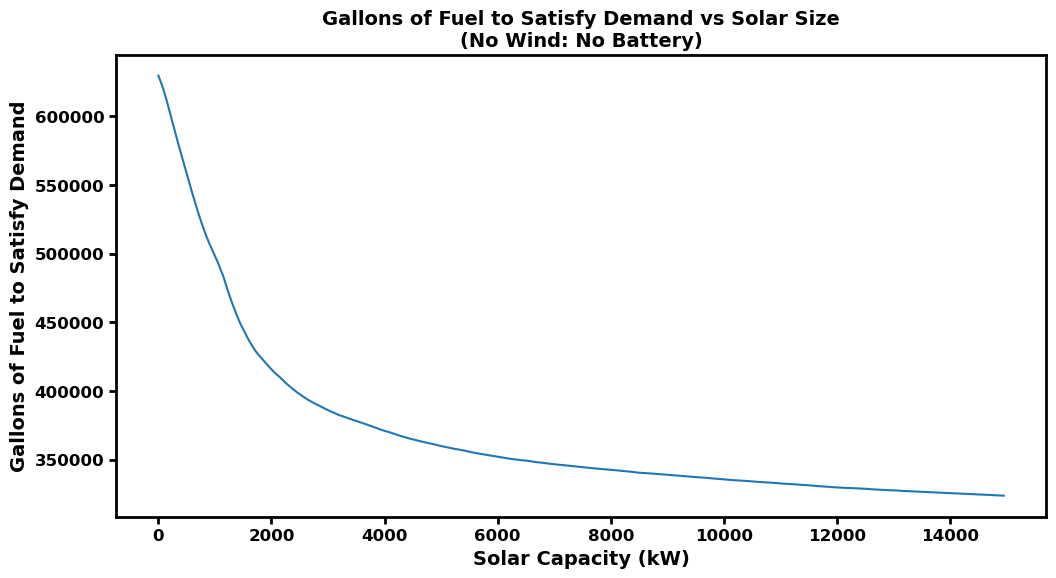

In [ ]:
#Solar, No wind, No Battery
solsize = np.arange(0, 15000, 50)
fdem = []
for i in solsize:
    fdem.append(simulate_energy(0, i, 0,0, 0))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Solar Size\n(No Wind: No Battery)')



#max 1,524,000
#min 670,000 


221866.82


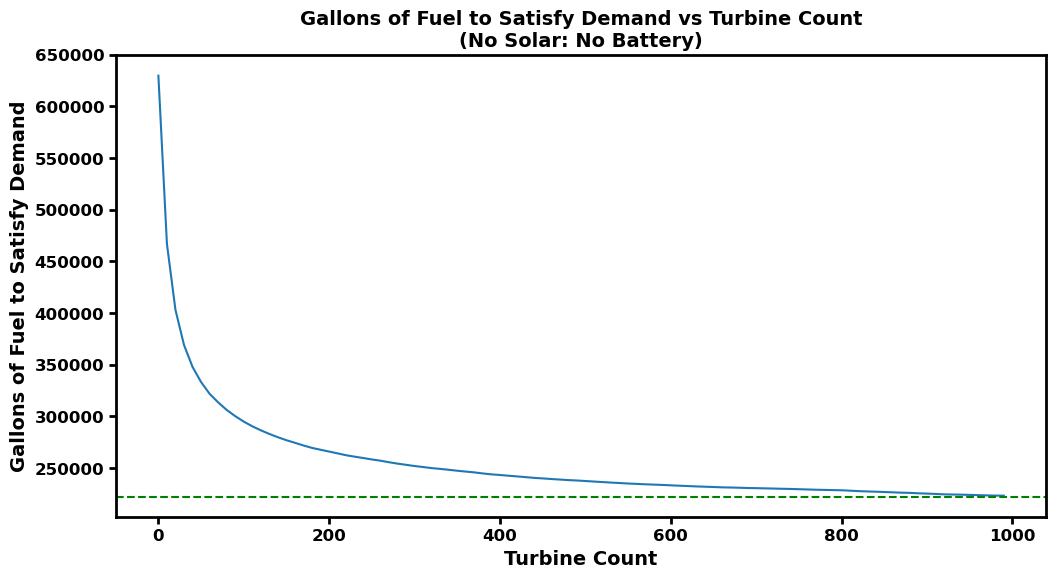

In [ ]:
#repeat for wind
#Wind, No Solar, No Battery
windsize = np.arange(0, 1000, 10)
fdem = []
for i in windsize:
    fdem.append(simulate_energy(i, 0, 0,0, 0))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(windsize, fdem)
plt.xlabel('Turbine Count')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Turbine Count\n(No Solar: No Battery)')
#return what value when fuel is minimized
#print the last 5 values
#find limit and draw line at horizontal limit
aymp = simulate_energy(1000000000000000,0,0,0,0)
print(aymp)
plt.axhline(y=aymp, color='g', linestyle='--')
#max 1,524,000
#min 534,000


Text(0.5, 1.0, 'Gallons of Fuel to Satisfy Demand vs Turbine Count\n(No Solar: No Battery)')

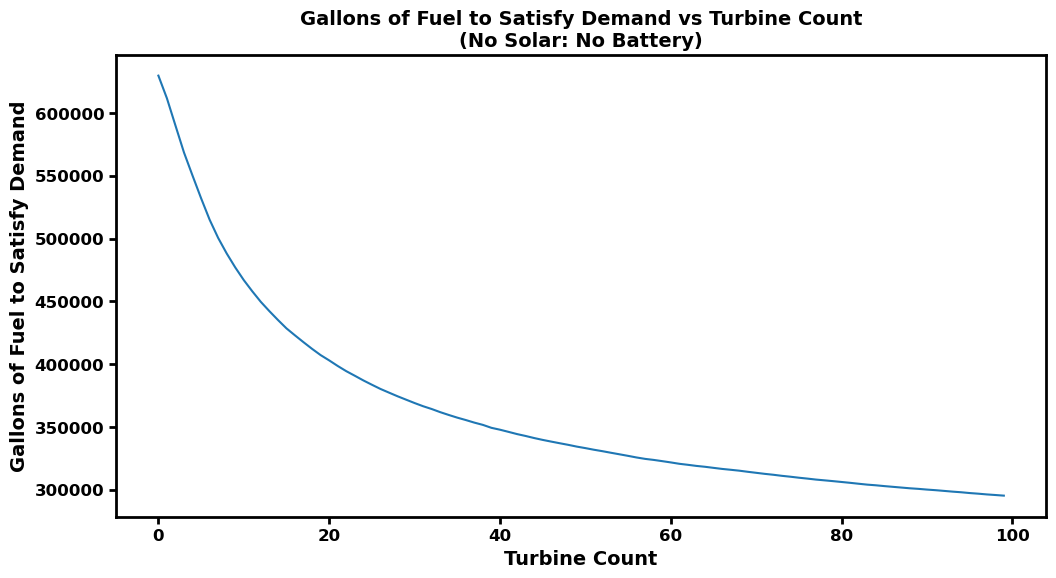

In [ ]:
#repeat for wind
#Wind, No Solar, No Battery
windsize = np.arange(0, 100, 1)
fdem = []
for i in windsize:
    fdem.append(simulate_energy(i, 0, 0,0, 0))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(windsize, fdem)
plt.xlabel('Turbine Count')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Turbine Count\n(No Solar: No Battery)')

1050
[196924.8, 196924.8, 196924.8, 196924.8, 196924.8]


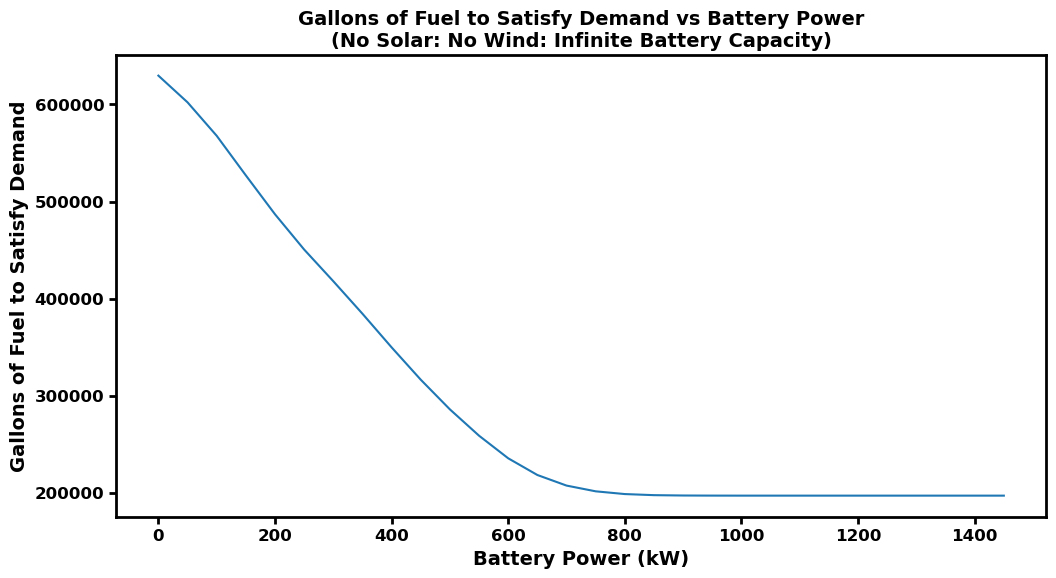

In [ ]:
#repeat for battery power
#Battery Power, No Solar, No Wind
battsize = np.arange(0, 1500, 50)
fdem = []
for i in battsize:
    fdem.append(simulate_energy(0, 0, 0,i, 100000000000000))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, fdem)
plt.xlabel('Battery Power (kW)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Battery Power\n(No Solar: No Wind: Infinite Battery Capacity)')

#return value when fuel is minimized
print(battsize[fdem.index(min(fdem))])
#1450
#print last 5 values
print(fdem[-5:])



12800
[88571.2, 88571.2, 88571.2, 88571.2, 88571.2]
281322.94


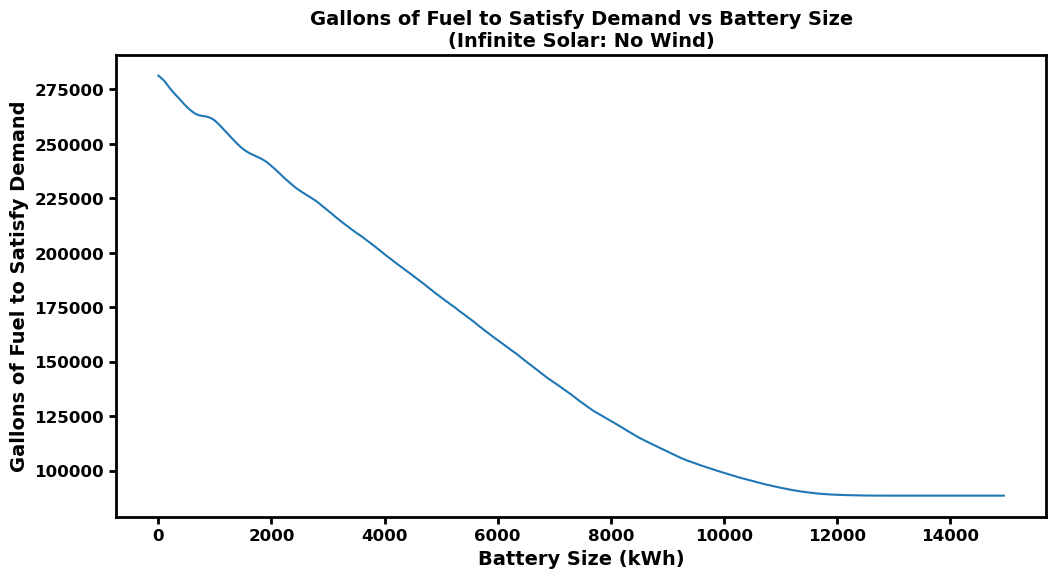

In [ ]:
#battery sizing infinite solar
battsize = np.arange(0, 15000, 50)
fdem = []
for i in battsize:
    fdem.append(simulate_energy(0, 1000000000000, 0,1450, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, fdem)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Solar: No Wind)')


print(battsize[fdem.index(min(fdem))])
print(fdem[-5:])

#14150 kWh battery satisfies all demand
#max is 670,000
print(max(fdem))

Text(0.5, 1.0, 'Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: No Solar)')

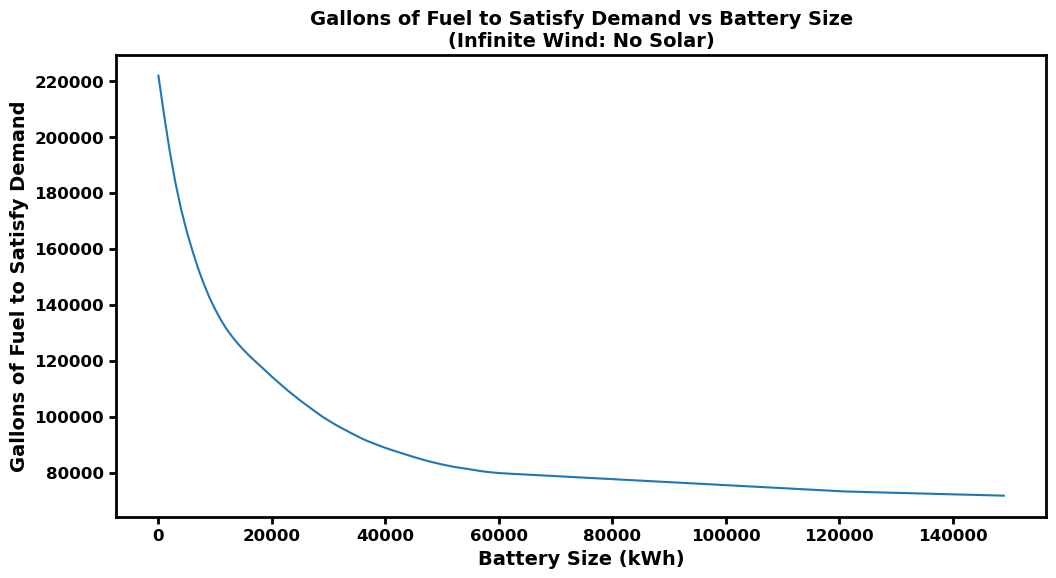

In [ ]:
#battery sizing infinite wind
battsize = np.arange(0, 150000, 1000)
fdem = []
for i in battsize:
    fdem.append(simulate_energy(1000000000000, 0, 0,1450, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, fdem)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: No Solar)')



Text(0.5, 1.0, 'Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: No Solar)')

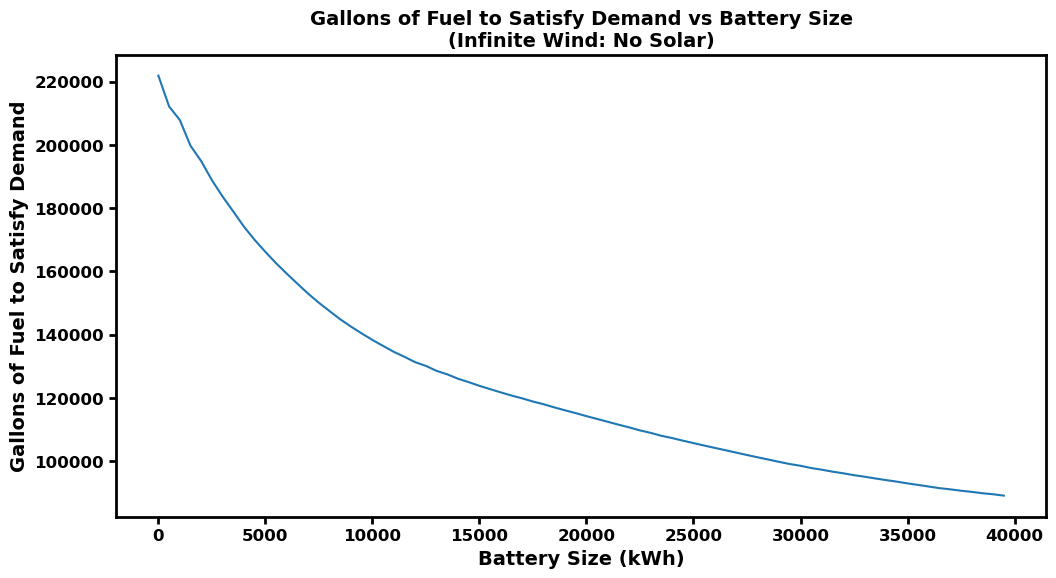

In [ ]:
#battery sizing infinite wind
battsize = np.arange(0, 40000, 500)
fdem = []
for i in battsize:
    fdem.append(simulate_energy(1000000000000, 0, 0,1450, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, fdem)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: No Solar)')


Text(0.5, 1.0, 'Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: Infinite Solar)')

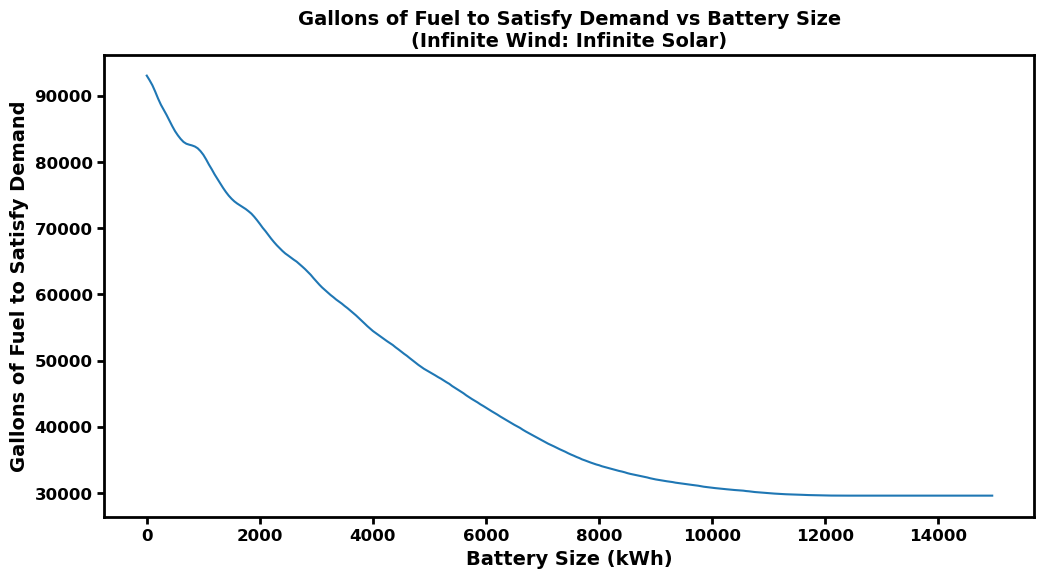

In [ ]:
#infinite wind and solar
battsize = np.arange(0, 15000, 50)
fdem = []
for i in battsize:
    fdem.append(simulate_energy(1000000000000, 1000000000000, 0,1450, i))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, fdem)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Battery Size\n(Infinite Wind: Infinite Solar)')


88571.2


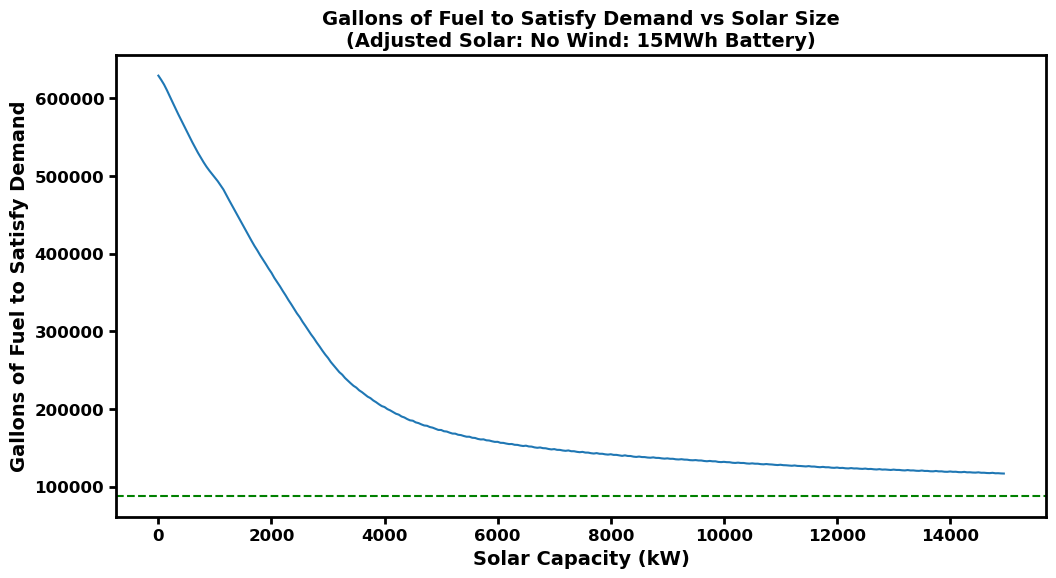

In [ ]:
#variable solar with 14500 battery 
solsize = np.arange(0, 15000, 50)
fdem = []
for i in solsize:
    fdem.append(simulate_energy(0, i, 0,1450, 15000))
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satisfy Demand')
plt.title('Gallons of Fuel to Satisfy Demand vs Solar Size\n(Adjusted Solar: No Wind: 15MWh Battery)')
#return what value when fuel is minimized
#print the last 5 values
#find limit and draw line at horizontal limit
aymp = simulate_energy(0,1000000000000000,0,1450,15000)
print(aymp)
plt.axhline(y=aymp, color='g', linestyle='--')




# Scenarios

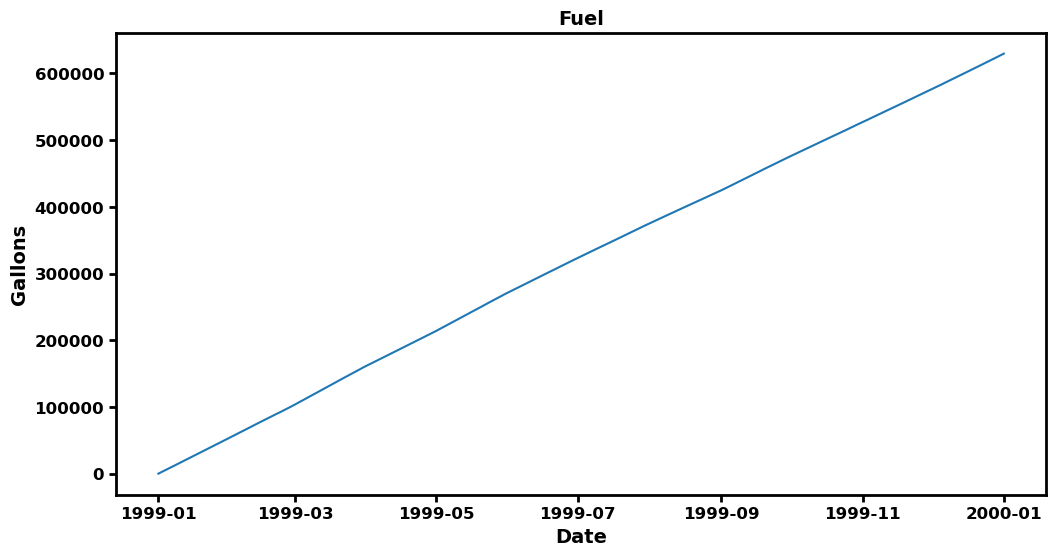

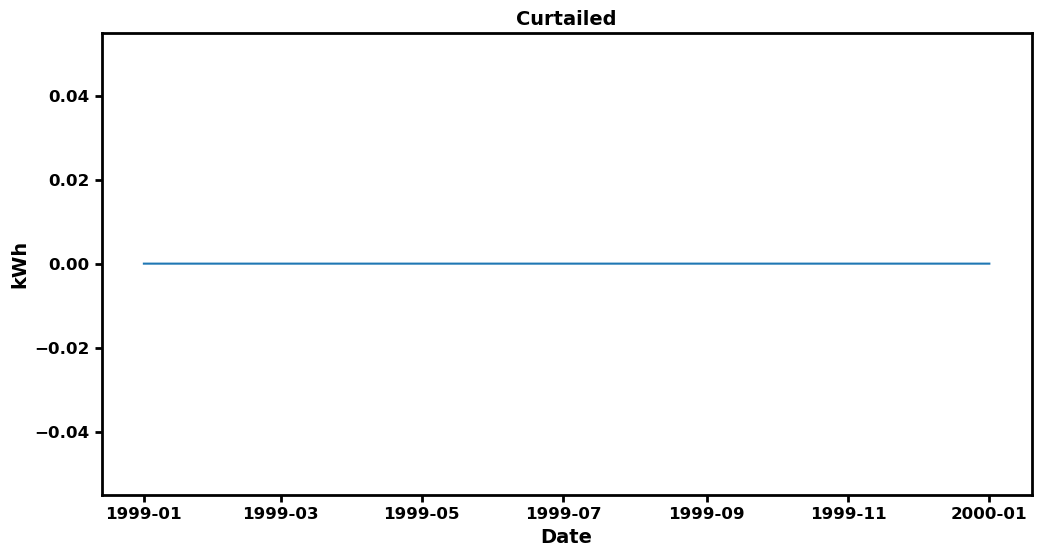

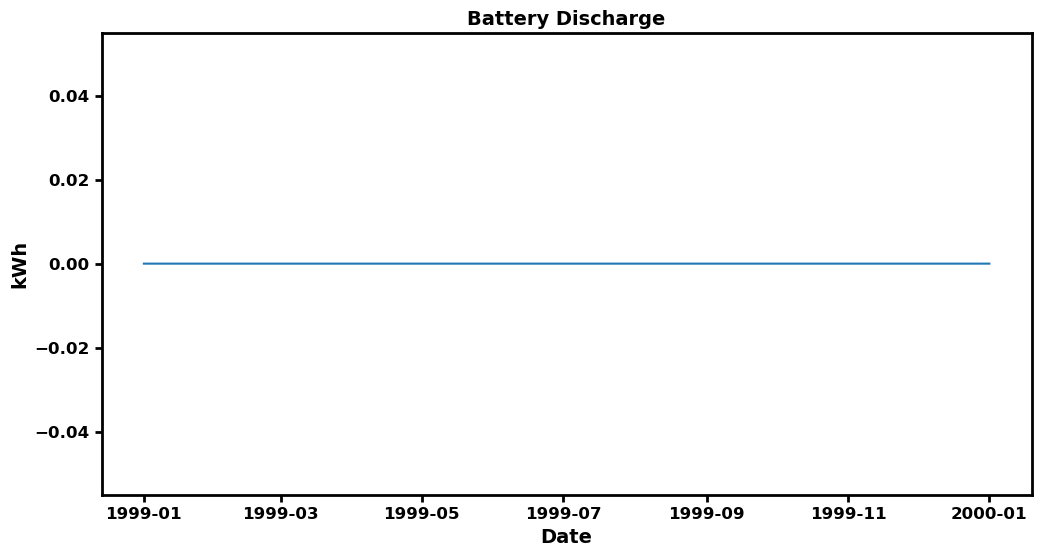

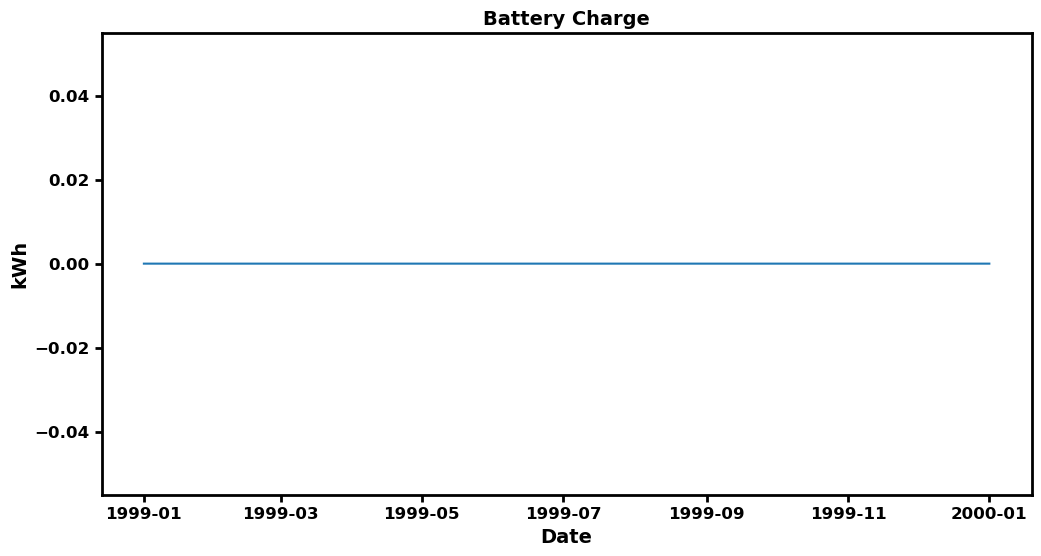

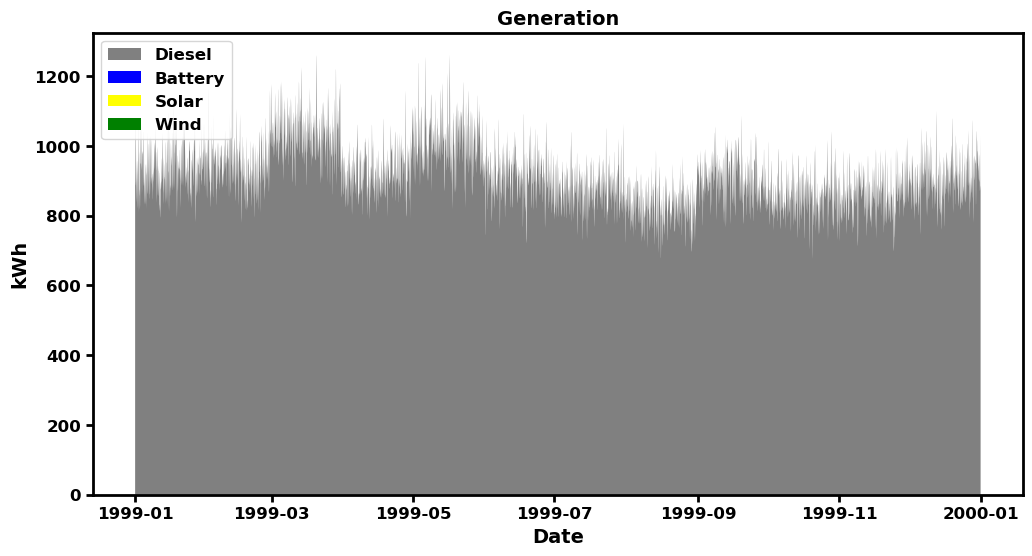

C:\Users\2023\AppData\Local\Temp\ipykernel_20984\1672893992.py:204: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([demand_line, curtailed_fill], ['Demand', 'Curtailed Energy'], loc='upper right')


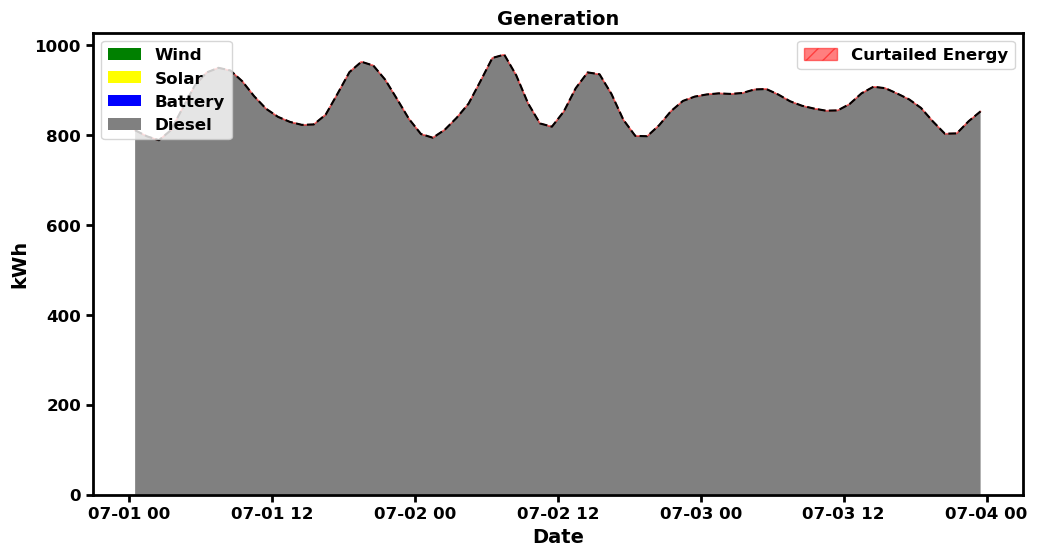

In [61]:
#Diesel Only 
diesel = simulate_energyscenario(0, 0, 0, 0 ,0)


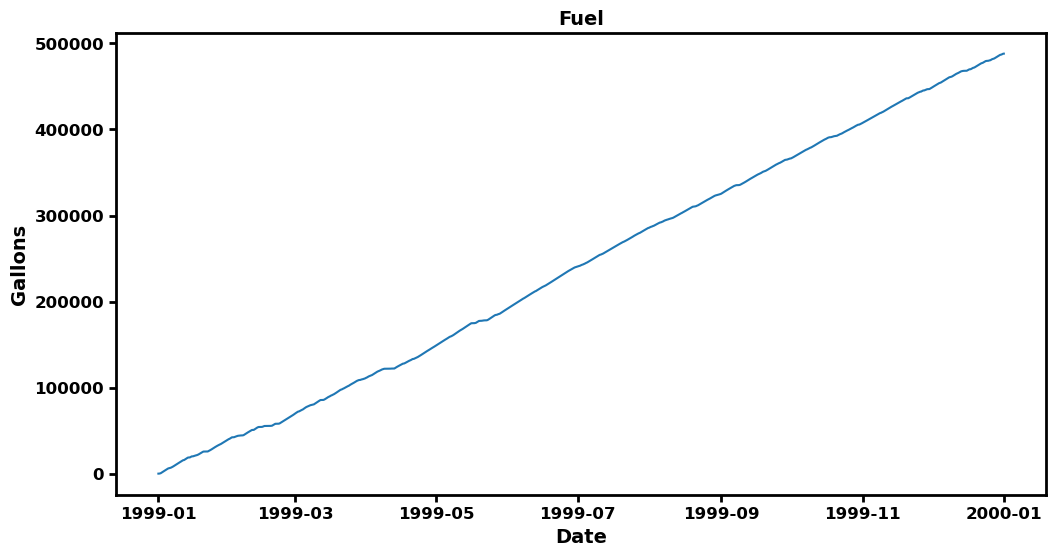

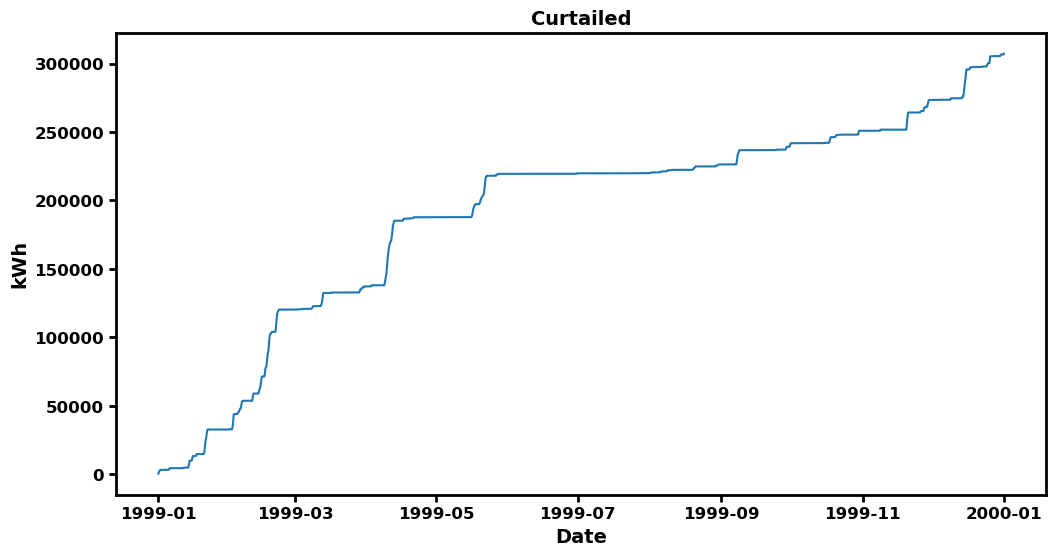

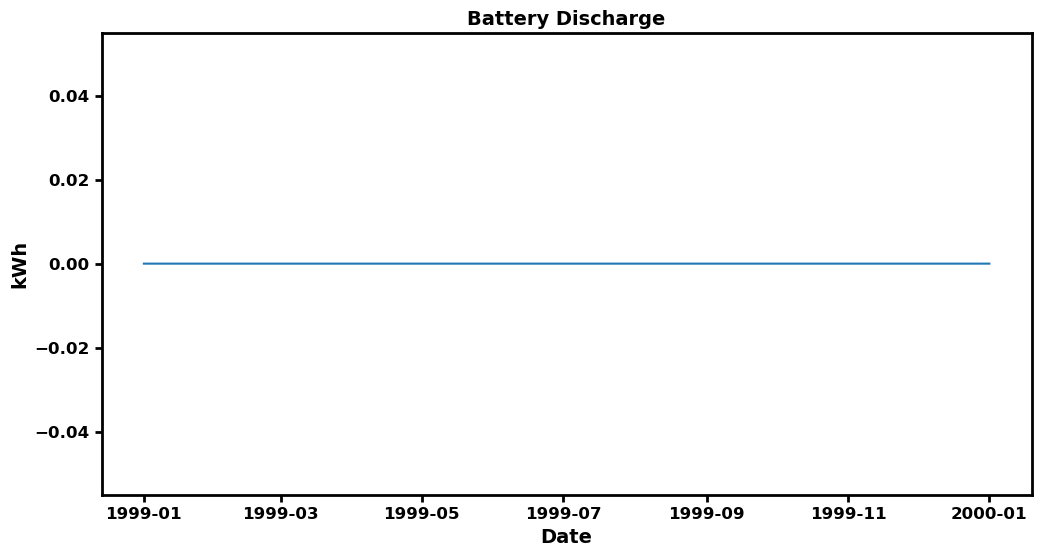

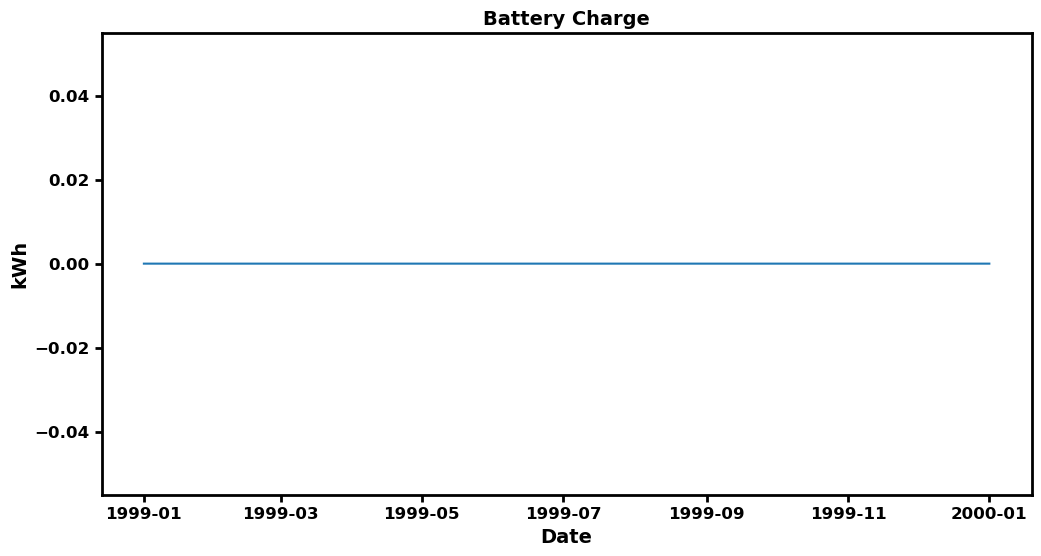

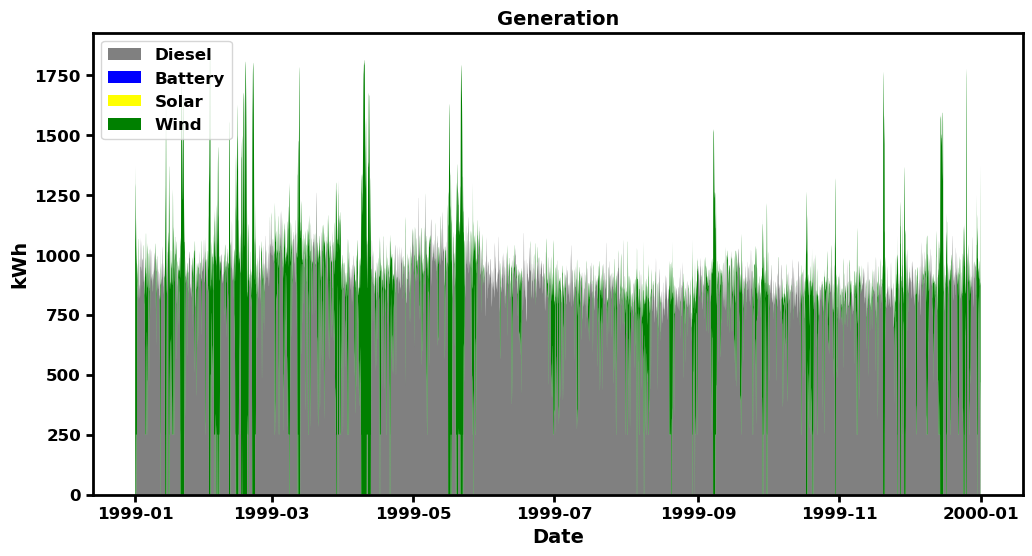

C:\Users\2023\AppData\Local\Temp\ipykernel_20984\2062952315.py:204: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([demand_line, curtailed_fill], ['Demand', 'Curtailed Energy'], loc='upper right')


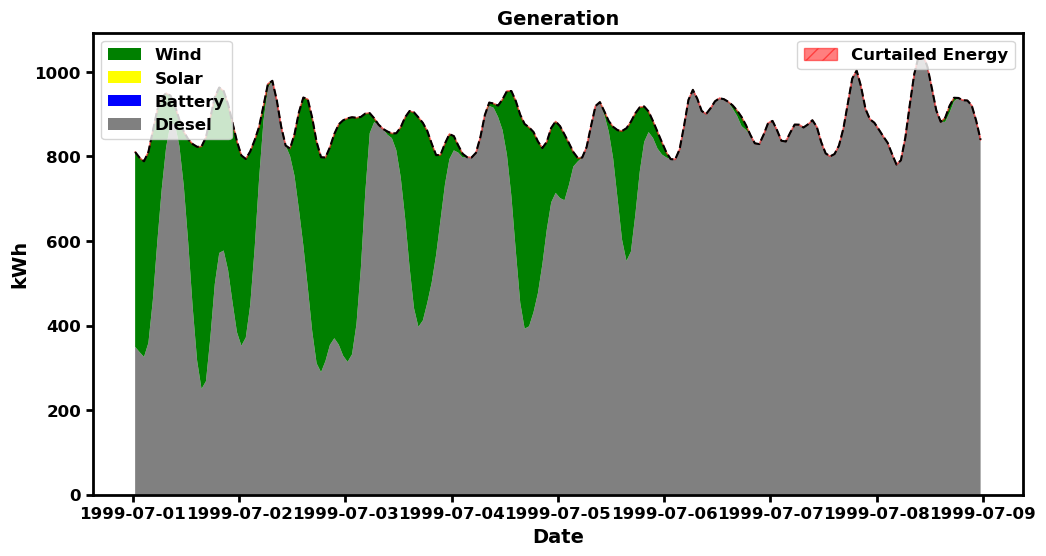

In [67]:
#Diesel and Wind
dieselwind = simulate_energyscenario(8, 0, 0, 0 ,0)



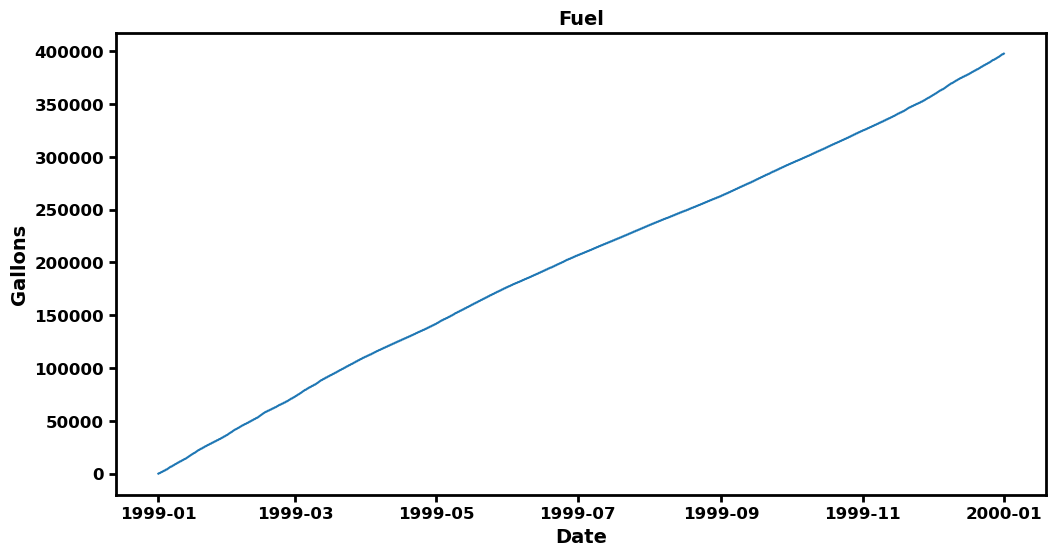

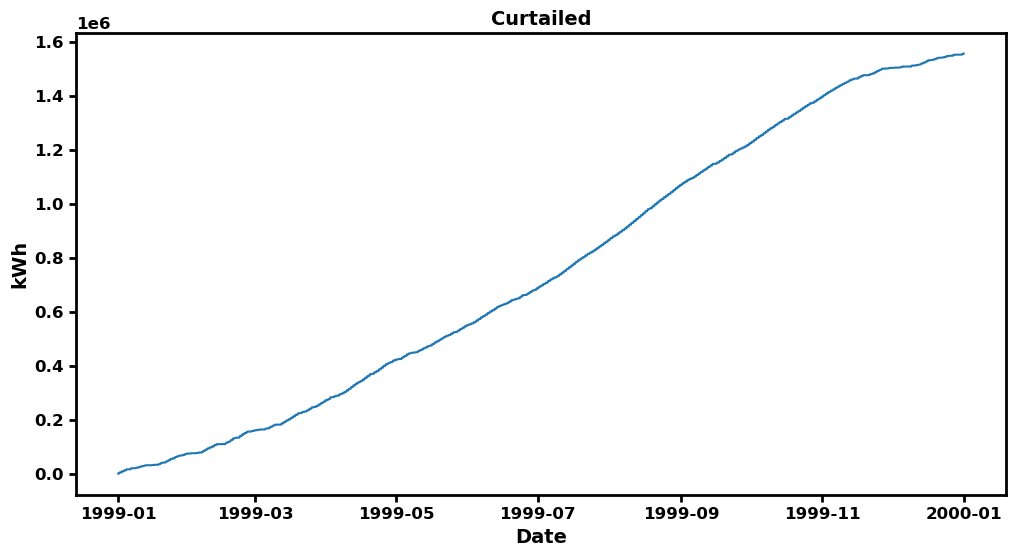

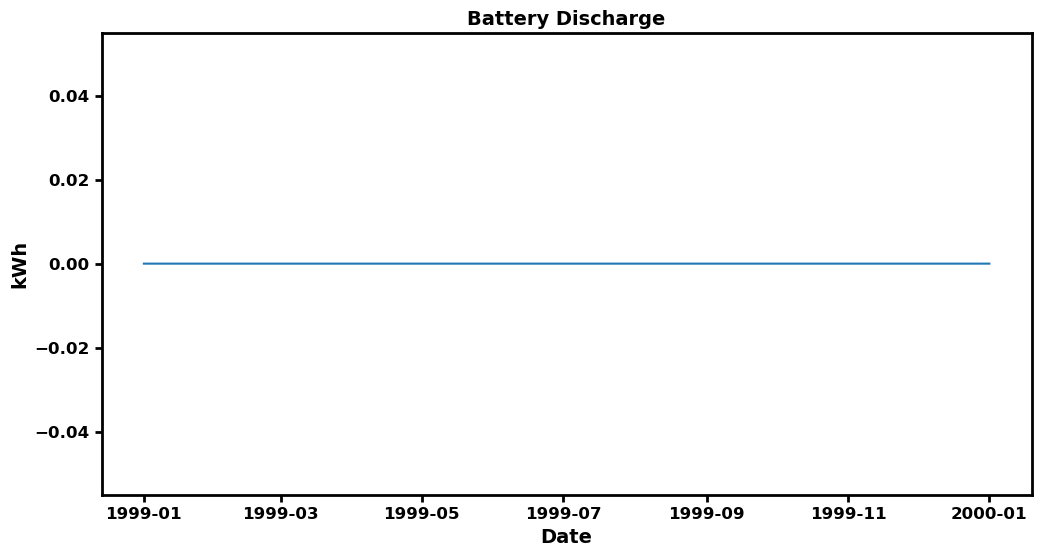

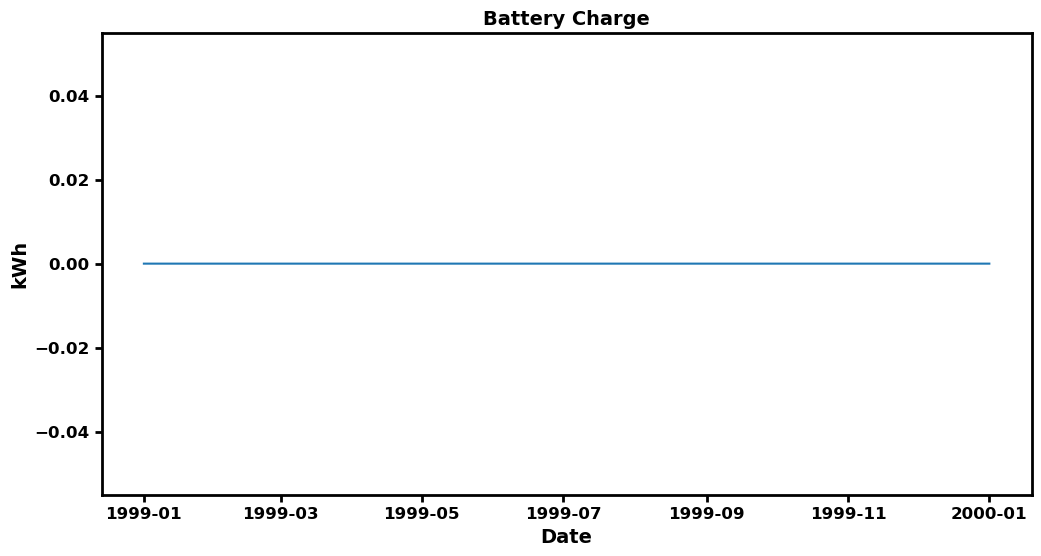

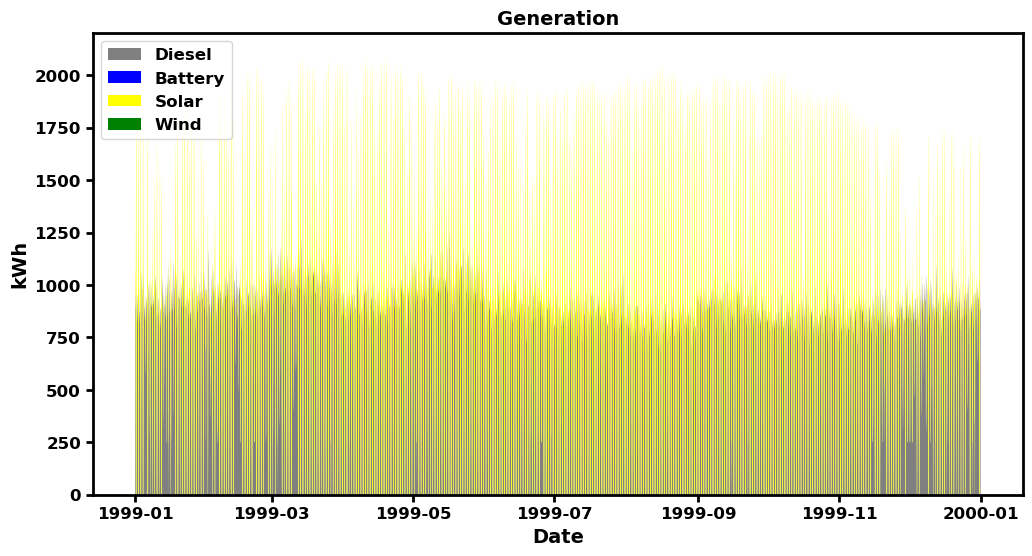

C:\Users\2023\AppData\Local\Temp\ipykernel_20984\2062952315.py:204: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([demand_line, curtailed_fill], ['Demand', 'Curtailed Energy'], loc='upper right')


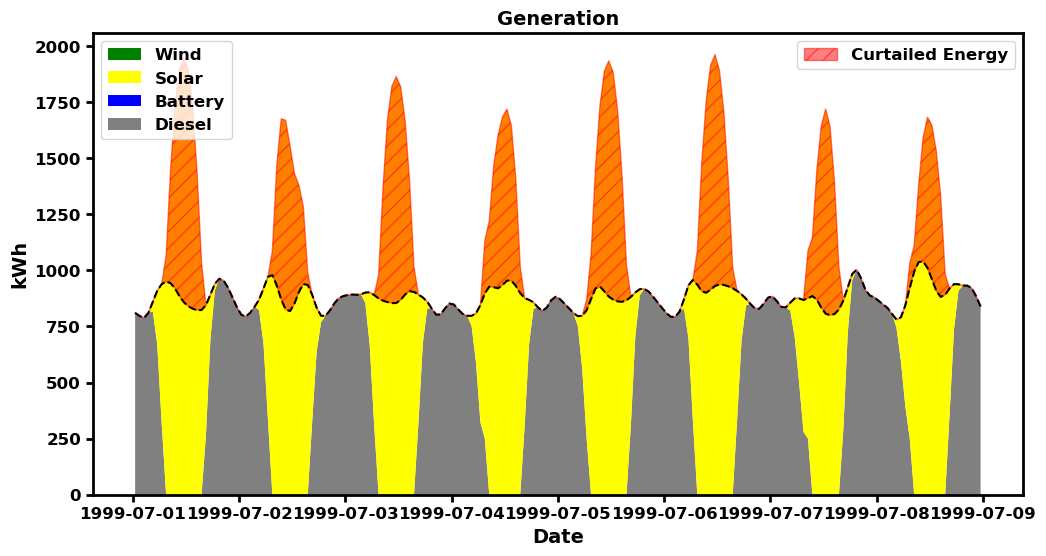

In [68]:
#diesel and solar
dieselsolar = simulate_energyscenario(0, 2500, 0, 0 ,0)


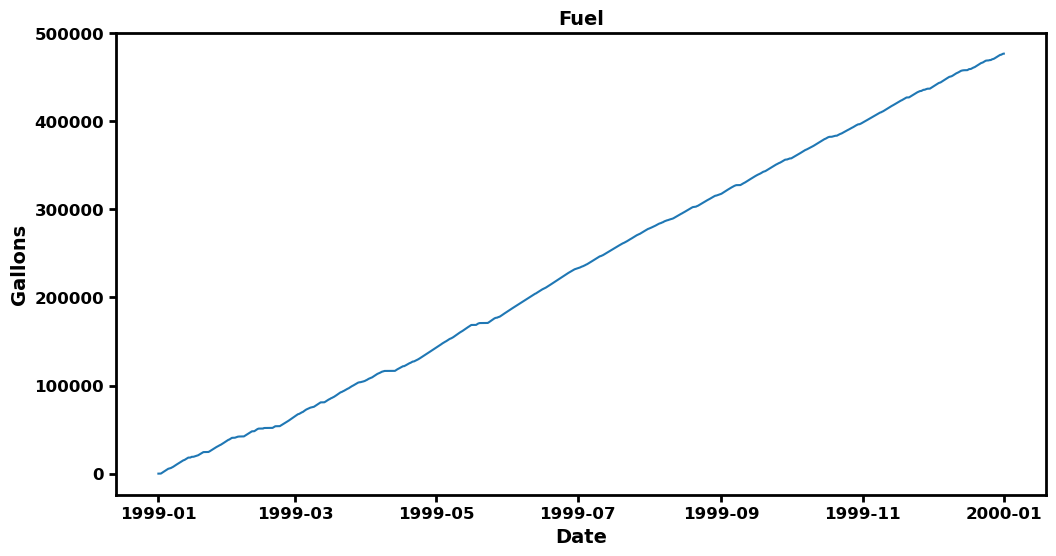

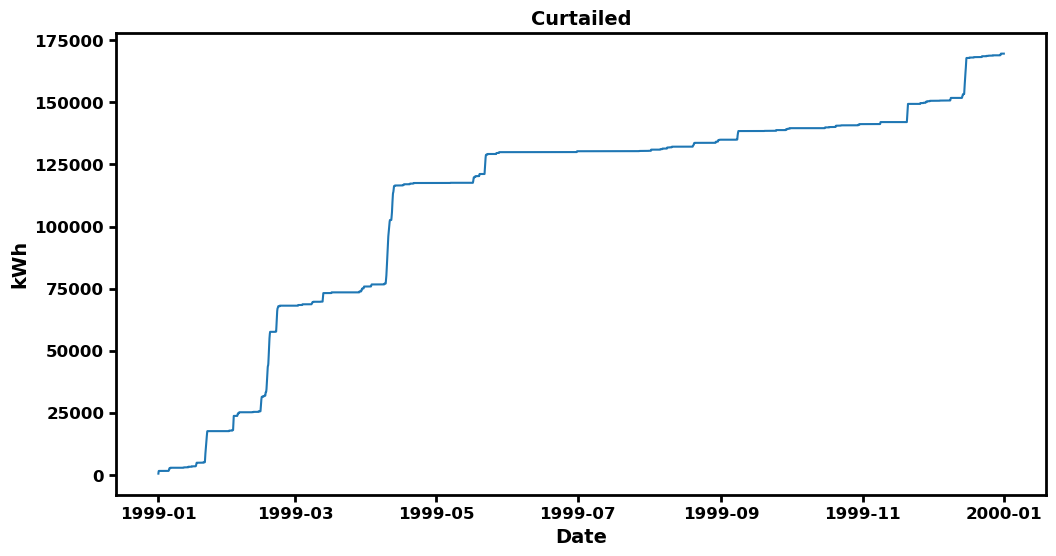

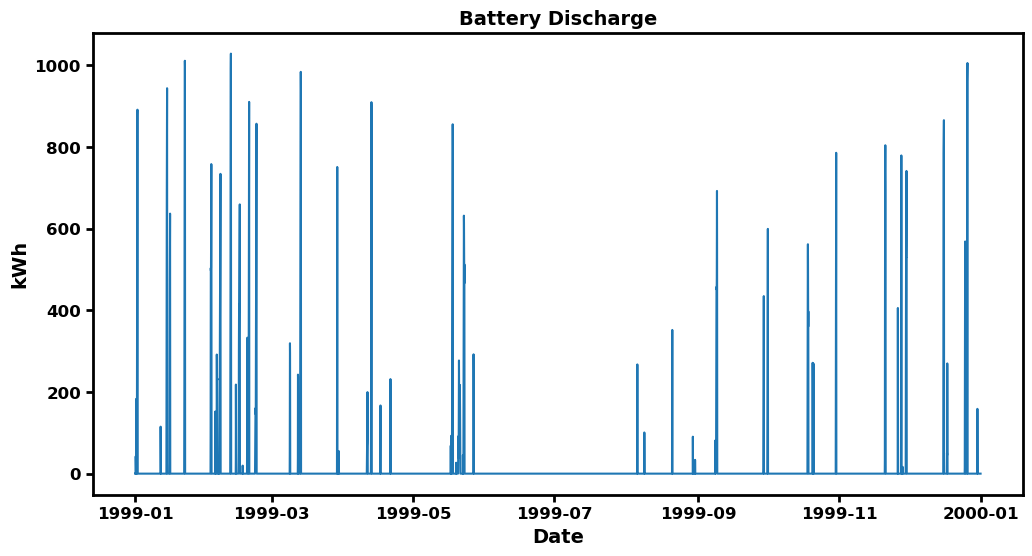

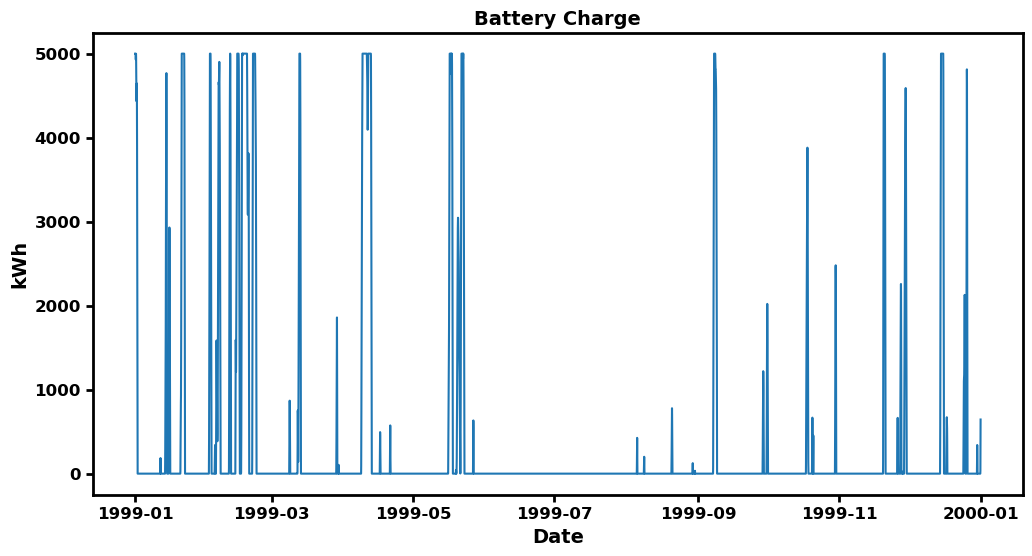

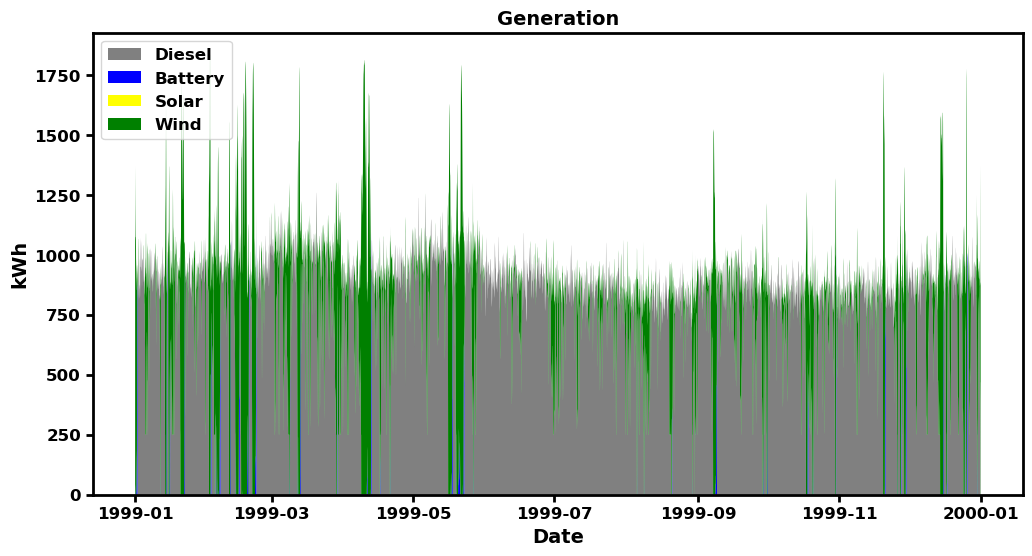

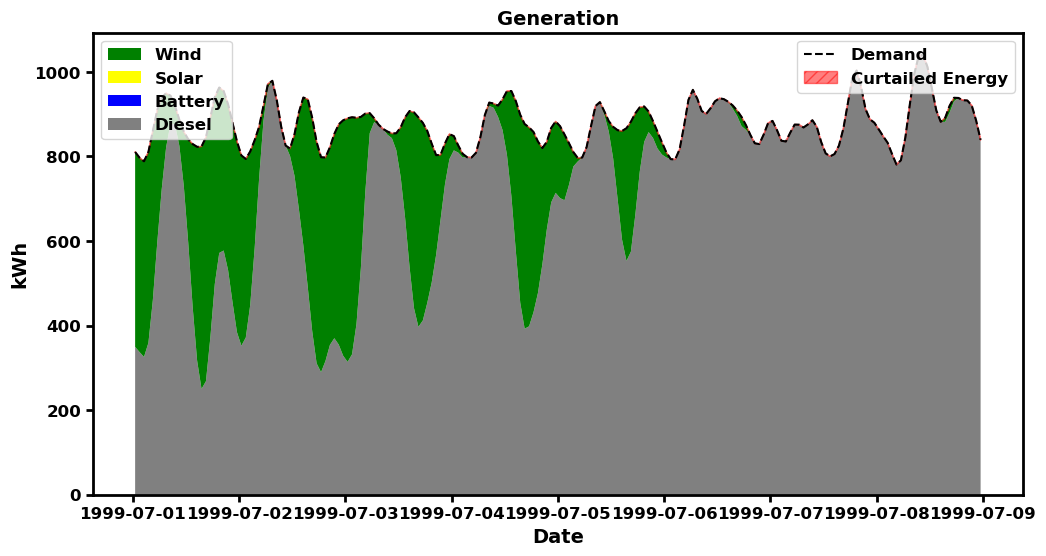

In [106]:
#diesel wind and battery
dieselwindbattery = simulate_energyscenario(8, 0, 0, 2000, 5000)

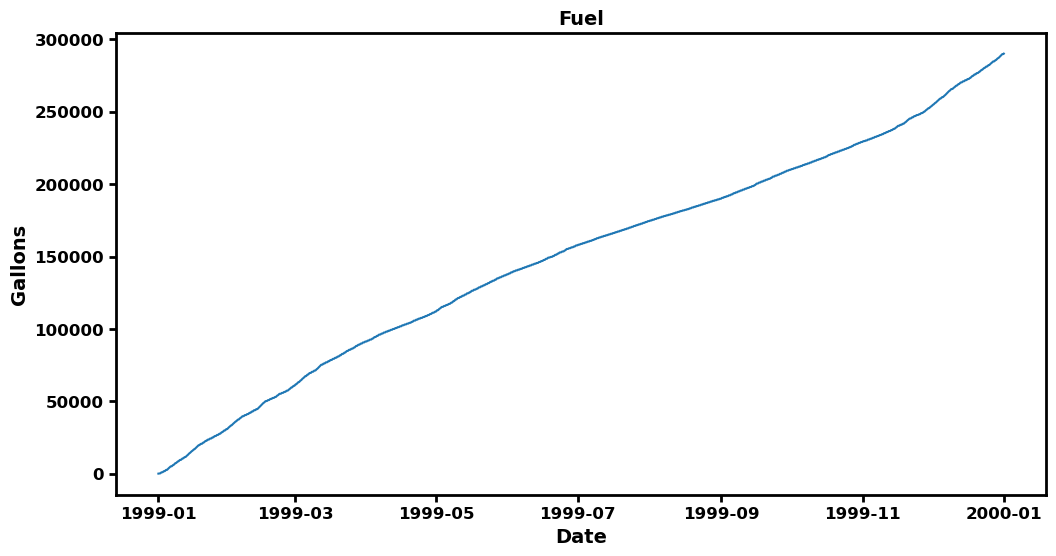

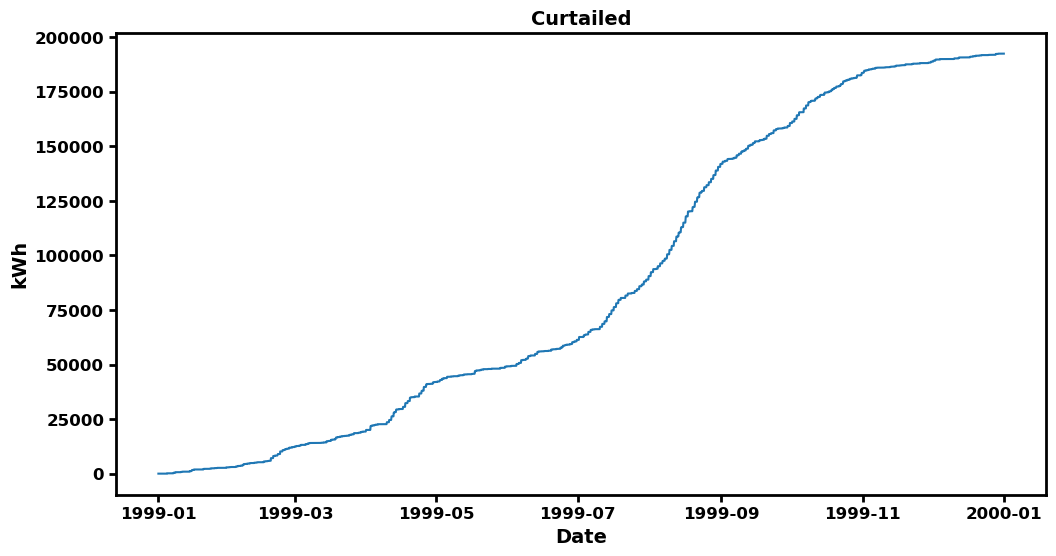

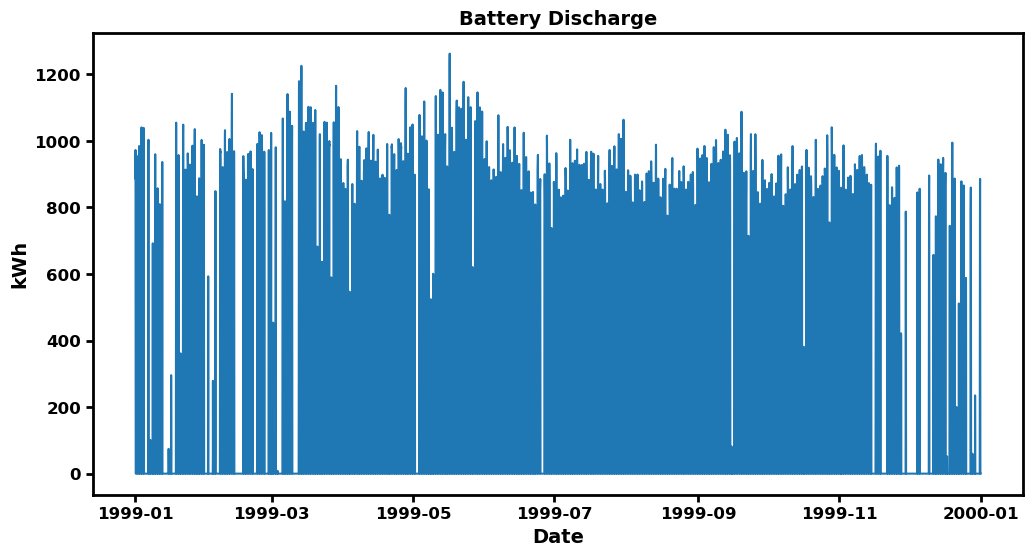

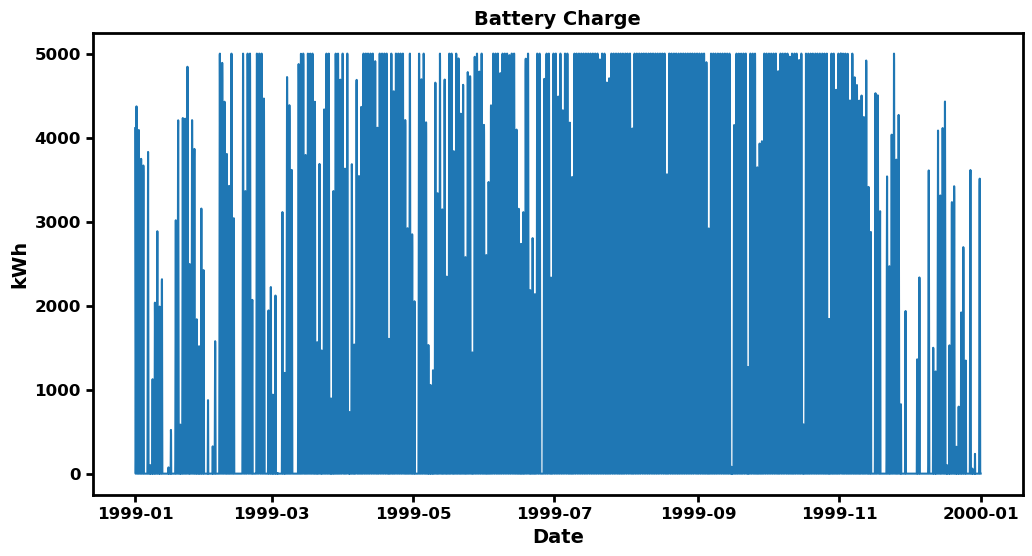

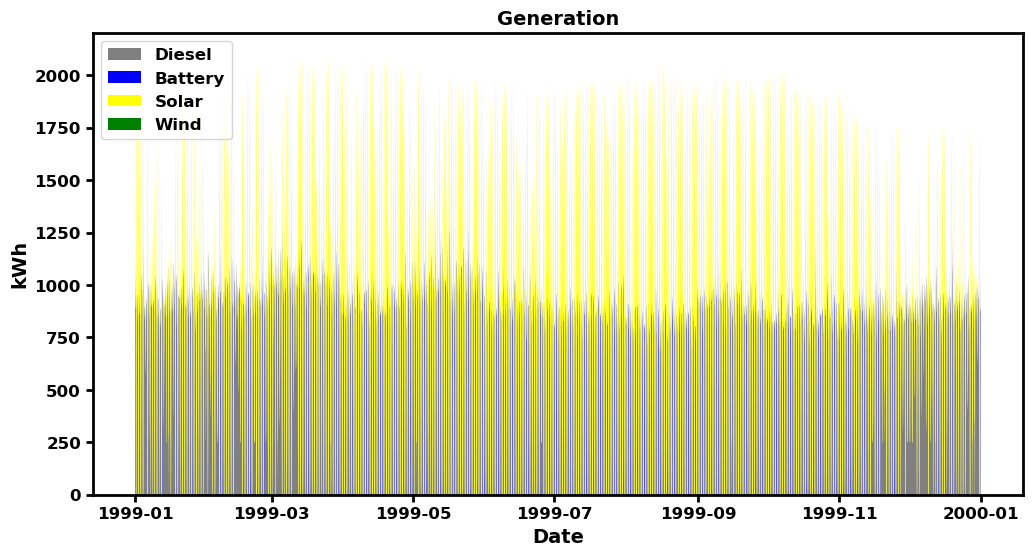

C:\Users\2023\AppData\Local\Temp\ipykernel_20984\2062952315.py:204: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([demand_line, curtailed_fill], ['Demand', 'Curtailed Energy'], loc='upper right')


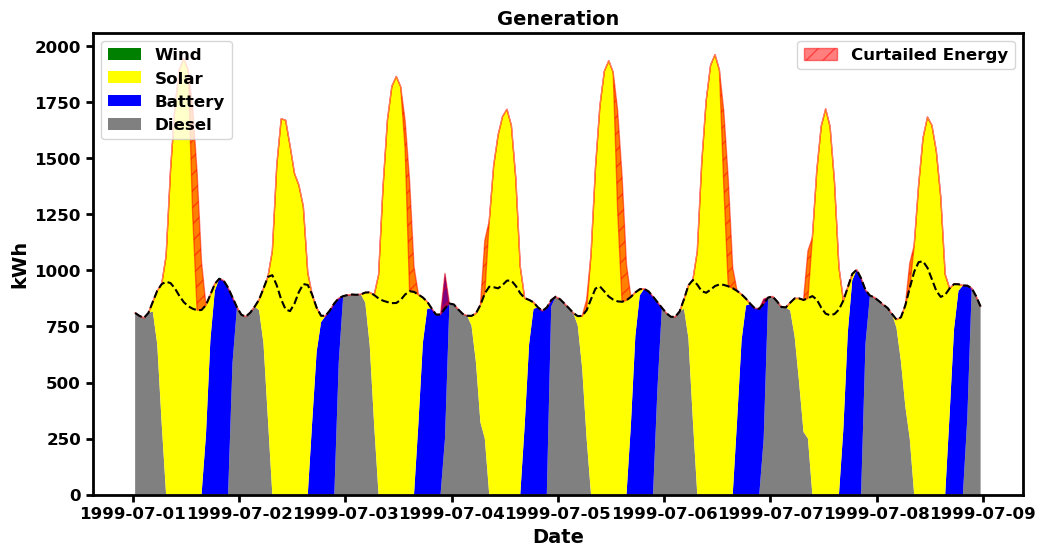

In [69]:
#Diesel solar and battery
dieselsolarbattery = simulate_energyscenario(0, 2500, 0, 2000, 5000)


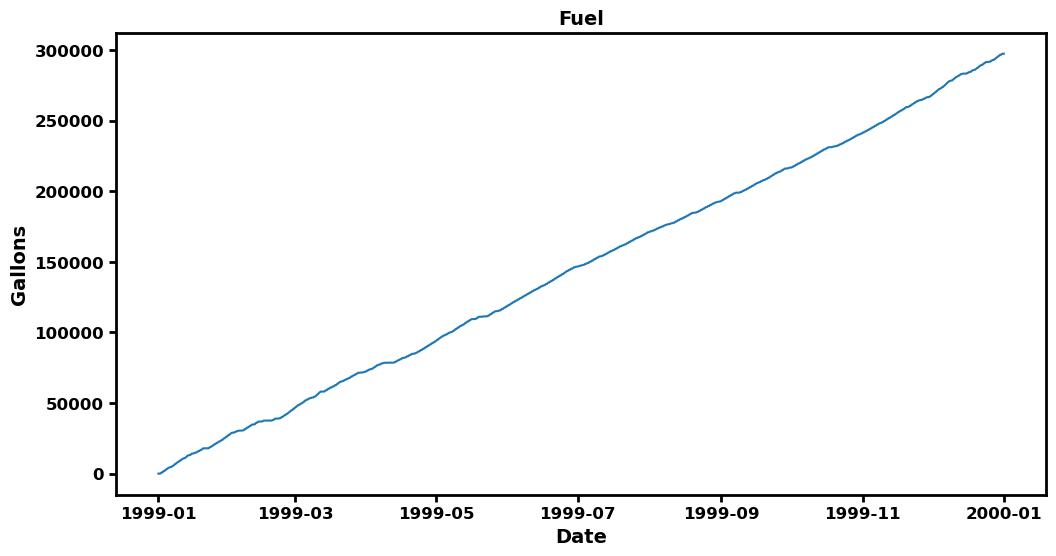

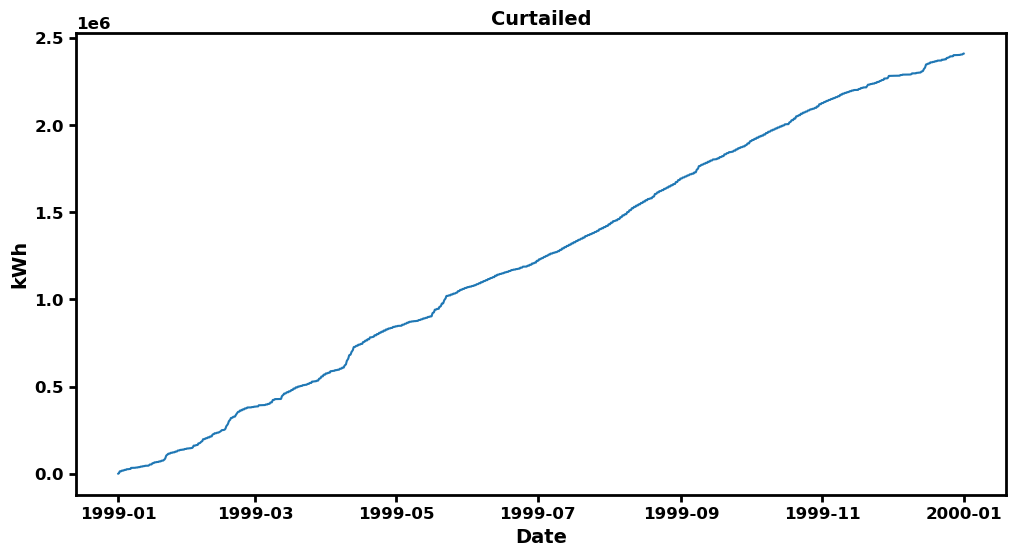

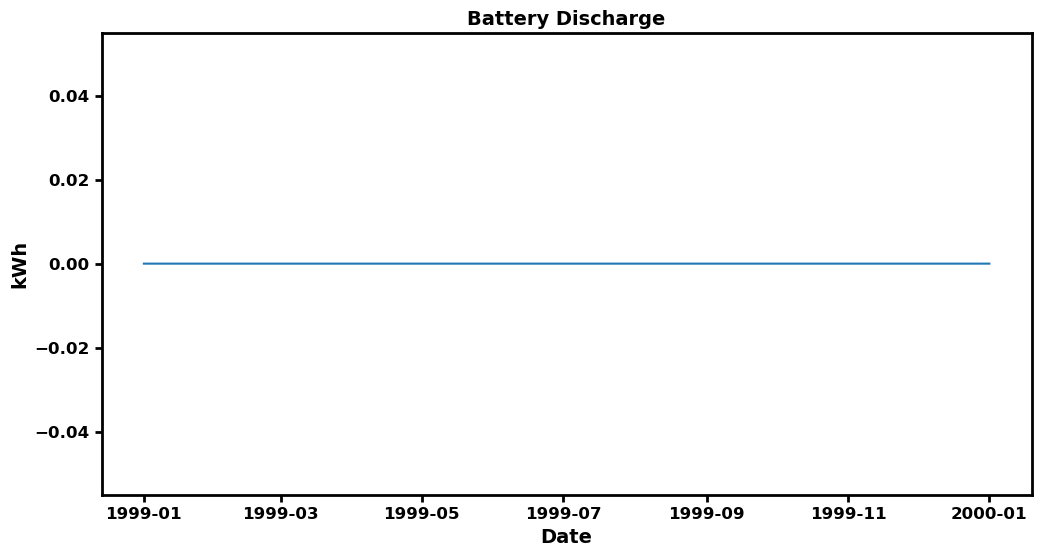

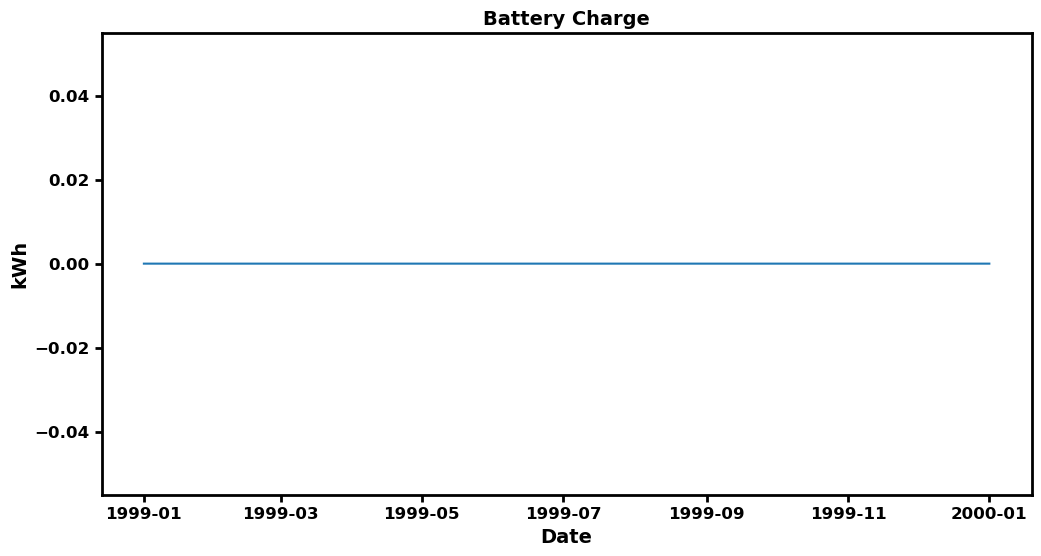

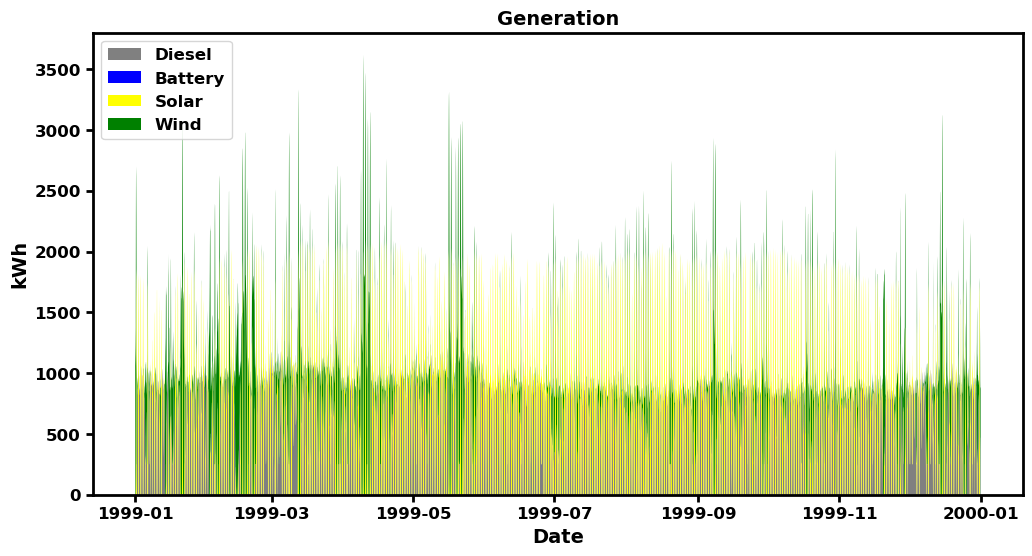

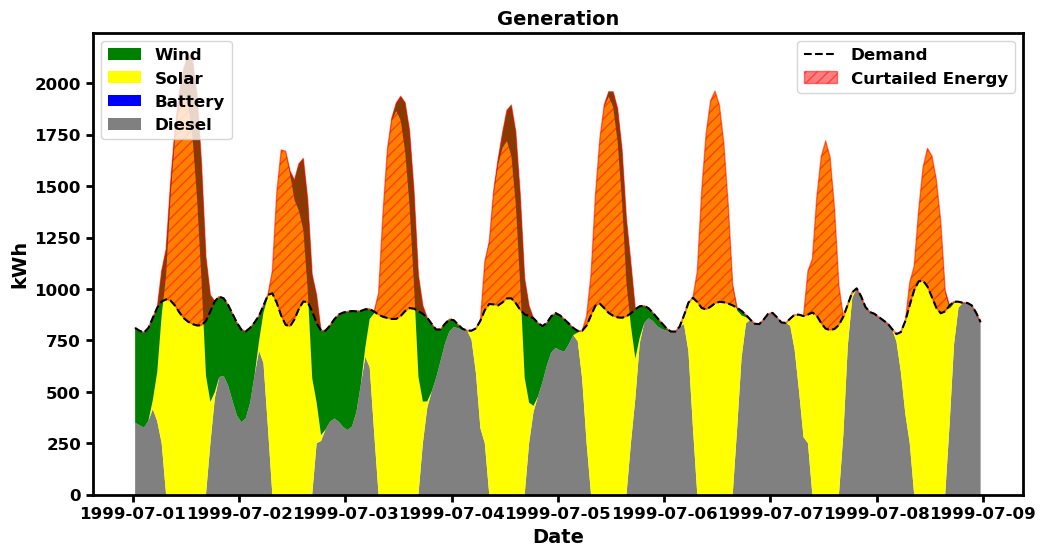

In [107]:
#diesel solar and wind
dieselsolarwind = simulate_energyscenario(8, 2500, 0, 0, 0)

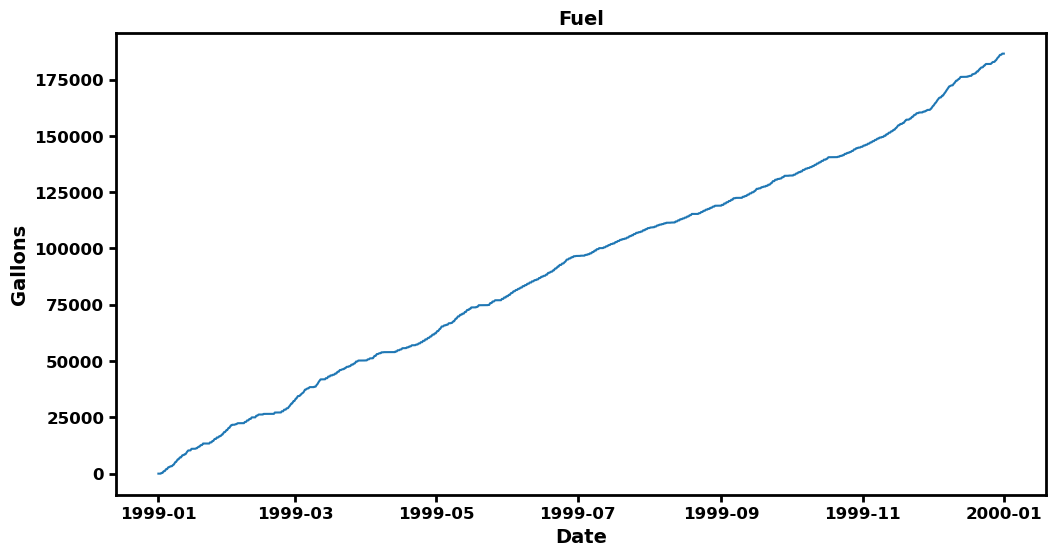

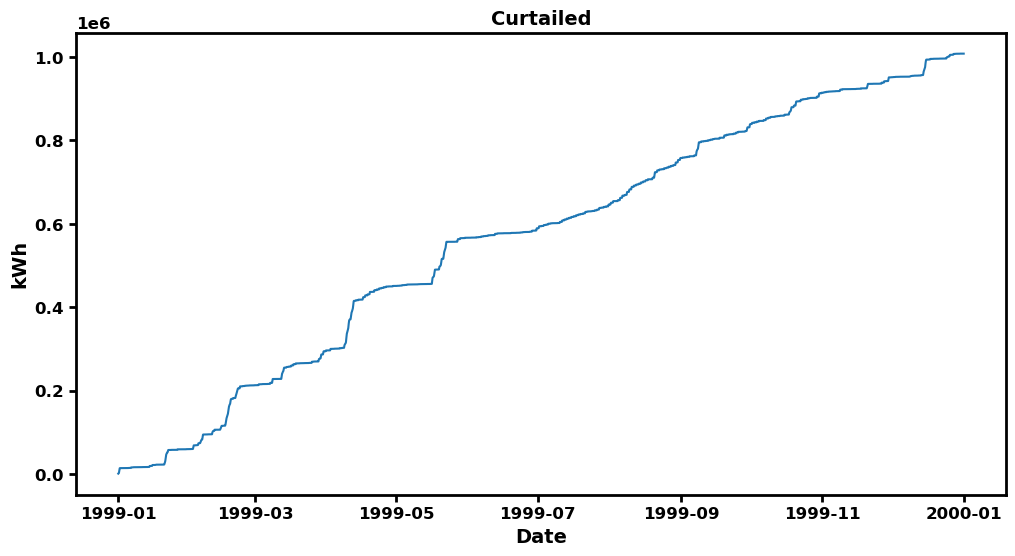

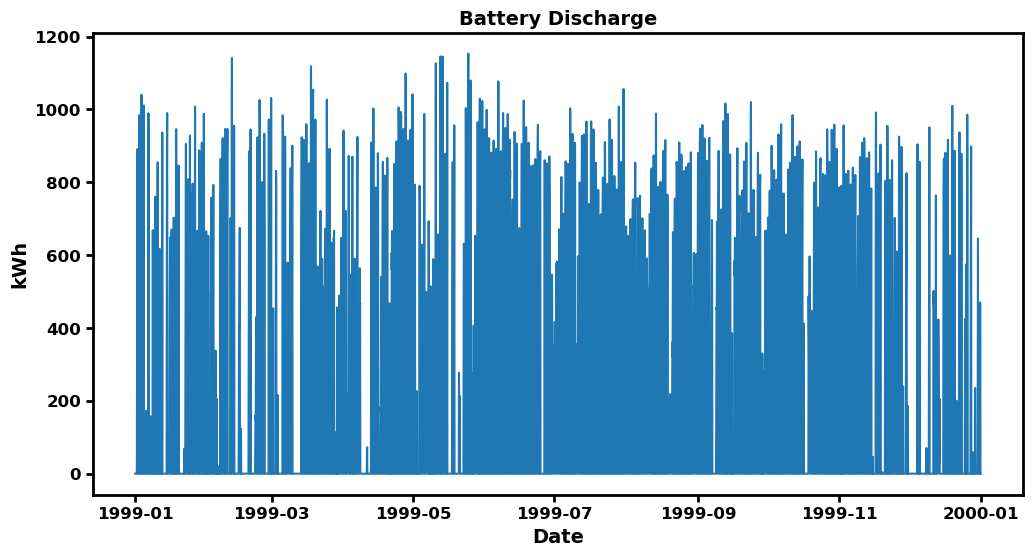

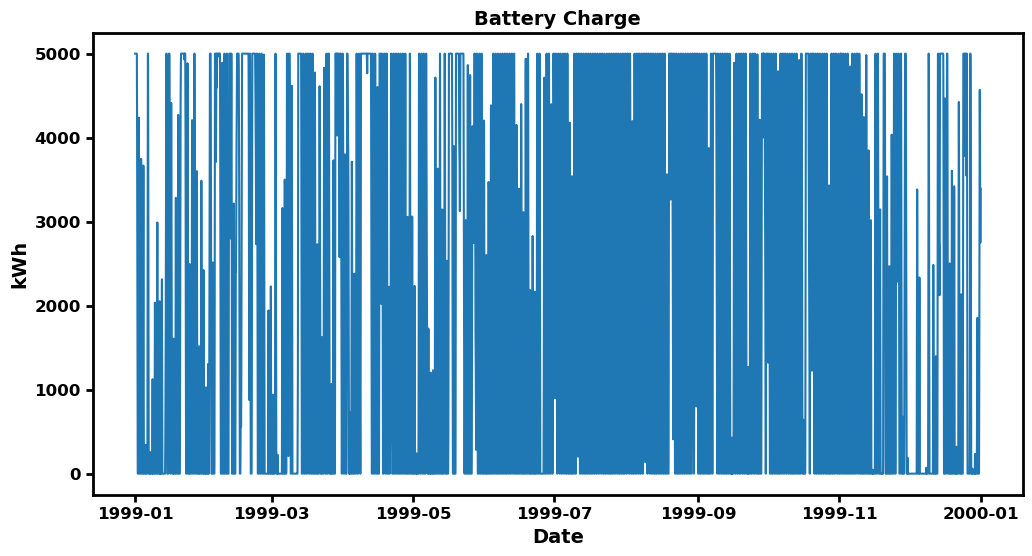

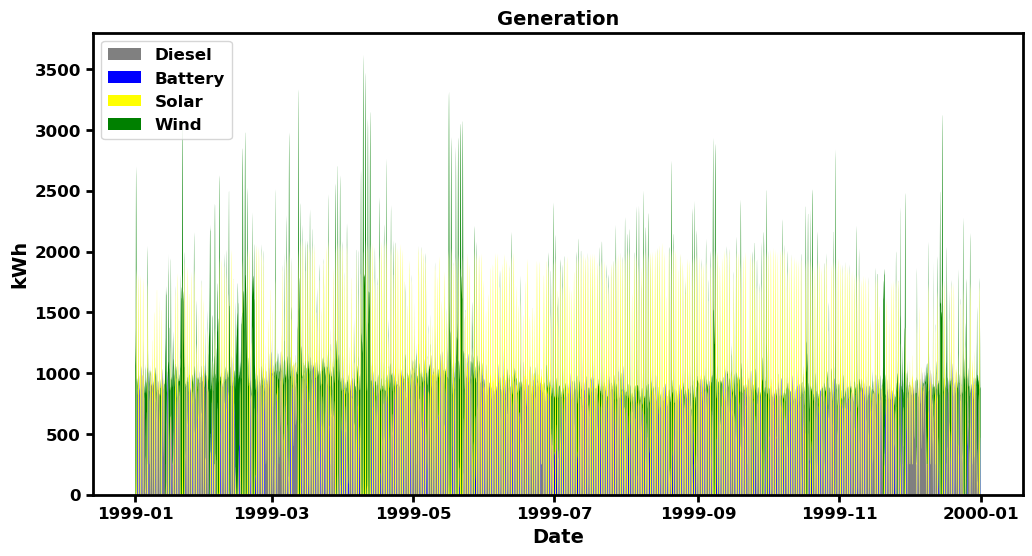

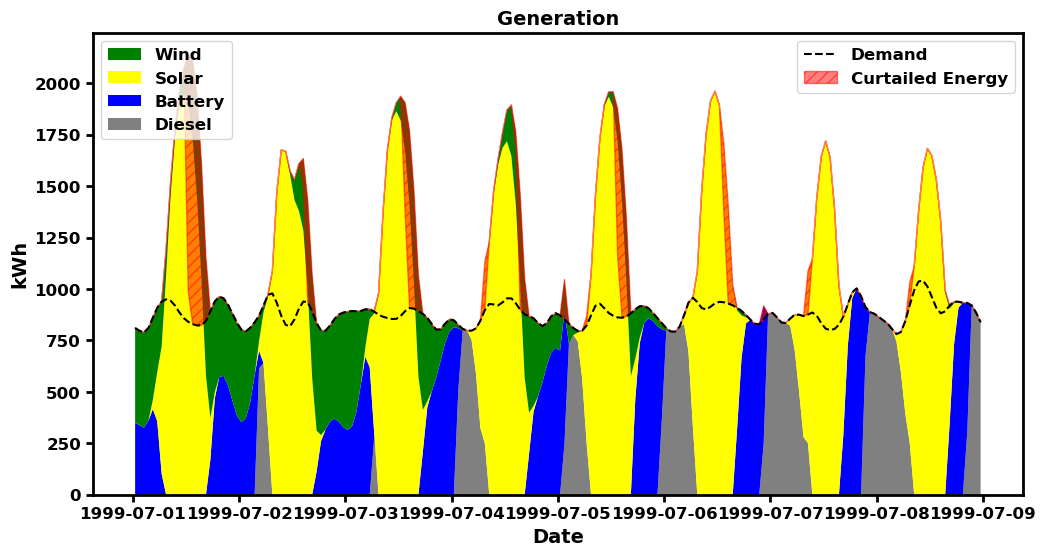

In [108]:
#diesel solar wind and battery
dieselsolarwindbattery = simulate_energyscenario(8, 2500, 0, 2000, 5000)


#Findings 

#Battery Infinite Solar: 14.5 MWh satisfies all demand, infl
#Battery Infinite Wind: 150 MWh satisfies all demand, 
#Battery Infinite Solar and Wind: 14 MWh satisfies all demand, 
#Consistent inflections around 750 and 1500

#The problem isnt the battery getting charged fully, its that the discharge is not enough to service the demand


#solar (15mWh steady): No difference until a little above 500 kW, begins increasing more over 1000kw. Battery shift didnt change
#Wind: Increase noted at 5 and above turbines

In [ ]:
#print sim data for two days in summer
#set battery data index to datetime
battery_data.index = pd.to_datetime(battery_data.index)
print(battery_data.index)
print(sim_data.index)

DatetimeIndex(['1999-01-01 00:30:00', '1999-01-01 01:30:00',
               '1999-01-01 02:30:00', '1999-01-01 03:30:00',
               '1999-01-01 04:30:00', '1999-01-01 05:30:00',
               '1999-01-01 06:30:00', '1999-01-01 07:30:00',
               '1999-01-01 08:30:00', '1999-01-01 09:30:00',
               ...
               '1999-12-31 14:30:00', '1999-12-31 15:30:00',
               '1999-12-31 16:30:00', '1999-12-31 17:30:00',
               '1999-12-31 18:30:00', '1999-12-31 19:30:00',
               '1999-12-31 20:30:00', '1999-12-31 21:30:00',
               '1999-12-31 22:30:00', '1999-12-31 23:30:00'],
              dtype='datetime64[ns]', name='Date', length=8760, freq=None)
DatetimeIndex(['1999-01-01 00:30:00', '1999-01-01 01:30:00',
               '1999-01-01 02:30:00', '1999-01-01 03:30:00',
               '1999-01-01 04:30:00', '1999-01-01 05:30:00',
               '1999-01-01 06:30:00', '1999-01-01 07:30:00',
               '1999-01-01 08:30:00', '1999-01-01 0

In [ ]:
#test for loop
#Battery
battery = []
battcap = 1000 #kwH
battpower = 1000 #kW
charge = battcap
discharge = []
curtailed = []
#make an array of test data
test = [-1200,-600,0,600,1200]
for i in test:
    if i > 0:
        if i > battpower:
            charge = charge + battpower
            curtail = i-battpower
        else:
            charge = charge + i
            curtail = 0 
        if charge > battcap:
            curtail = curtail + charge - battcap
            charge = battcap
        battery.append(charge)
        discharge.append(0)
        curtailed.append(curtail)
    else:
        if i < -battpower:
            charge = charge - battpower
            if charge <= 0:
                discharge.append(charge + battpower)
                charge = 0
            else:
                discharge.append(battpower)
        else:
            charge = charge + i
            if charge <= 0:
                discharge.append(charge-i)
                charge = 0
            else:
                discharge.append(-i)
        battery.append(charge)
        curtailed.append(0)
    curtail = 0


print(battery)
print(discharge)
print(curtailed)

[0, 0, 0, 600, 1000]
[1000, 0, 0, 0, 0]
[0, 0, 0, 0, 800]
